In [12]:
import argparse
import pysam
from pathlib import Path
import pandas as pd
import copy

In [13]:
#manually identified the inversion reads
inversion_reads = ['m84127_240712_175808_s4/246483519/ccs',
'm84127_240712_175808_s4/165154071/ccs',
'm84127_240712_175808_s4/41227253/ccs',
'm84127_240802_194716_s2/230297831/ccs',
'm84127_240802_194716_s2/91030239/ccs',
'm84127_240712_175808_s4/45553173/ccs',
'm84127_240712_175808_s4/69734245/ccs',
'm84127_240712_175808_s4/25760525/ccs',
'm84127_240712_175808_s4/200609304/ccs',
'm84127_240712_175808_s4/212337140/ccs',
'm84127_240712_175808_s4/60817797/ccs',
'm84127_240712_175808_s4/223613241/ccs',
'm84127_240712_175808_s4/246221764/ccs',
'm84127_240712_175808_s4/5771352/ccs']

In [14]:
#extracting the coordinates of the exonic regions in c9orf72
ex1_coord = (27573431,27573481)
ex2_coord = (27573709,27573866)
between = (27573481, 27573709)

#for the region between the start of exon1 and end of exon2 - extract the deletion and insertion coordinates
#input:
#     read
#     l: location in the reference
#     l_read: the location in the read where enters exon1 (not ness. same as ref loc)
#     segment_index: which cigar tuple we are at

the_read = None
def check_exonic_overlaps(read, l, l_read, segment_index):
    read_del_lst = []
    read_ins_lst = []
    for op, length in read.cigartuples[segment_index:]:
        if l > ex2_coord[1]:
            return read_del_lst, read_ins_lst
        if op == 0:  
            l_read += length
            l += length
        elif op == 1:
            l_read += length
            start = l
            end = l + length
            read_ins_lst.append((start, end))
        elif op == 2:  # Deletion
            start = l
            end = l + length
            l += length
            read_del_lst.append((start, end))
        elif op == 3:  # Skipped region
            l += length #moving ahead in the reference

        elif op == 4:  # Soft clipping
            l_read += length
            l += length 
        elif op == 5:  # Hard clipping 
            pass
        elif op == 6:  # Padding
            pass
        elif op == 7:  # Segment equal 
            l_read += length
            l += length
        elif op == 8:
            l_read += length
            l += length
        else:
            raise ValueError(f"Unknown CIGAR operation code {op}")

    return read_del_lst, read_ins_lst

def find_deletion_locs(inbam):
    deletions = []
    insertions = []
    count = 0

    for read in inbam.fetch("chr9", 27557179, 27580459):
        count += 1
        
        read_start = read.reference_start
        read_end = read.reference_end
        
        if read_start < ex1_coord[0] or read.query_name in inversion_reads:
            ref_start = read.reference_start  # Correct attribute for reference start position
    
            if read.cigartuples[0][0] == 4:
                ref_start = ref_start - read.cigartuples[0][1]
    
            cigar = read.cigartuples
    
            #the bases traversed - where we are in the read
            l_read = 0
            #the exact start position of the read - where we are in the reference
            l = ref_start
    
            segment_index = 0
            for op, length in cigar:
                #if we are at the exonic region in the read
                if l + length > ex1_coord[0]:
                    deletion_lst, insertion_lst = check_exonic_overlaps(read, l, l_read, segment_index)
                    deletions.append(deletion_lst)
                    insertions.append(insertion_lst)
                    break
    
                if op == 0:  # NOT SURE WHAT THE MEANING OF THIS IS
                    l_read += length
                    l += length
    
                elif op == 1:  # Insertion (this is correct)
                    l_read += length
    
                elif op == 2:  # Deletion (this is correct)
                    l += length
    
                elif op == 3:  # Skipped region
                    l += length #moving ahead in the reference
    
                elif op == 4:  # Soft clipping
                    l_read += length
                    l += length #
    
                elif op == 5:  # Hard clipping NOT SURE
                    pass
                elif op == 6:  # Padding NOT SURE
                    pass
                elif op == 7:  # Segment equal (this is correct)
                    l_read += length
                    l += length
                elif op == 8:  # seems to be sequence mismatcj - they both advance then NOT SURE
                    l_read += length
                    l += length
                else:
                    print('here')
                    raise ValueError(f"Unknown CIGAR operation code {op}")
    
                segment_index += 1
    return deletions, insertions
    # Close the BAM file
    inbam.close()

228
['m84127_240712_175808_s4/246483519/ccs', 'm84127_240712_175808_s4/165154071/ccs', 'm84127_240712_175808_s4/41227253/ccs', 'm84127_240802_194716_s2/230297831/ccs', 'm84127_240802_194716_s2/91030239/ccs', 'm84127_240712_175808_s4/45553173/ccs', 'm84127_240712_175808_s4/69734245/ccs', 'm84127_240712_175808_s4/25760525/ccs', 'm84127_240712_175808_s4/200609304/ccs', 'm84127_240712_175808_s4/212337140/ccs', 'm84127_240712_175808_s4/60817797/ccs', 'm84127_240712_175808_s4/223613241/ccs', 'm84127_240712_175808_s4/246221764/ccs', 'm84127_240712_175808_s4/5771352/ccs']


In [15]:
'''IMPORTANT LOCATIONS IN THE FILE'''
ex1_coord = (27573431-1,27573481)
ex2_coord = (27573709-1,27573866)
between = (27573481-1,27573709)

c_loc = (27573507-1,27573527) 
g4_loc = (27573648-1,27573668) 
g11_loc = (27573547-1,27573567)
g12_loc = (27573546-1,27573566)
g13_loc = (27573545-1,27573565)
repeat = (27573528-1, 27573547)

def del_types(inbam, group = 'None'):
    deletions_lst, insertions_lst = find_deletion_locs(inbam) #adding an insertion list!

    #the left guide in this case was the c
    lg_loc = (27573507-1,27573527)
    rg_loc = (0,0)

    if group.endswith('g4'):
        rg_loc = g4_loc
    elif group.endswith('g11'):
        rg_loc = g11_loc
    elif group.endswith('g12'):
        rg_loc = g12_loc
    elif group.endswith('g13'):
        rg_loc = g13_loc

    num_reads = len(deletions_lst)

    #exisions lists
    exision_intronic_lst = [0 for i in range(num_reads)]
    exision_ex1_lst = [0 for i in range(num_reads)]
    exision_ex2_lst = [0 for i in range(num_reads)]
    exision_ex1_ex2_lst = [0 for i in range(num_reads)]

    #deletion lists
    intronic_del_lst = [0 for i in range(num_reads)] #not including gRNA loc
    ex1_del_lst = [0 for i in range(num_reads)]
    ex2_del_lst = [0 for i in range(num_reads)]
    guide_del_lst = [0 for i in range(num_reads)] #deletion at either grna target site

    #insertion lists
    intronic_ins_lst = [0 for i in range(num_reads)] #not including gRNA loc
    ex1_ins_lst = [0 for i in range(num_reads)]
    ex2_ins_lst = [0 for i in range(num_reads)]
    guide_ins_lst = [0 for i in range(num_reads)] #insertion at either grna target site

    nothing = 0
    if len(deletions_lst) == 0:
        nothing = 1

    index = 0
    for read in deletions_lst:
        found_ex1_indel = False
        found_ex2_indel = False
        found_ex1_ex2_indel = False
        found_intronic_indel = False

        for deletion in read:
            #the deletion is intronic (1)
            if between[0] < deletion[0] and deletion[1] < between[1]:
                #spans the repeat region
                if deletion[0] <= repeat[0] and deletion[1] >= repeat[1]:
                    exision_intronic_lst[index] = 1
                else:
                    if (rg_loc[0] < deletion[0] <= rg_loc[1]) or (rg_loc[0] < deletion[1] <= rg_loc[1]) or (lg_loc[0] < deletion[1] <= lg_loc[1]) or (lg_loc[0] < deletion[0] <= lg_loc[1]):
                        guide_del_lst[index] += 1
                    elif (deletion[0] <= rg_loc[0] and deletion[1] >= rg_loc[0]) or (deletion[0] <= rg_loc[1] and deletion[1] >= rg_loc[1]):
                        guide_del_lst[index] += 1
                    elif (deletion[0] <= lg_loc[0] and deletion[1] >= lg_loc[0]) or (deletion[0] <= lg_loc[1] and deletion[1] >= lg_loc[1]):
                        guide_del_lst[index] += 1
                    else:
                        intronic_del_lst[index] += 1

            #deletion slices out some of the exon
            else:
                #spans both exons (3)
                if deletion[0] < ex1_coord[1] and deletion[1] > ex2_coord[0]:
                    exision_ex1_ex2_lst[index] += 1
                #excision which overlaps with ex1, but not ex2 (4)
                elif deletion[0] <= ex1_coord[1] and deletion[1] >= repeat[1]:
                    exision_ex1_lst[index] += 1
                #overlaps with ex2 (not ex1) (5)
                elif deletion[0] <= repeat[0] and deletion[1] >= ex2_coord[0]:
                    exision_ex2_lst[index] += 1
                #deletion which overlaps with exon 1 (but doesn't lead to an excision) (6)
                elif deletion[0] < ex1_coord[1]:
                    ex1_del_lst[index] += 1
                #deletion which overlaps with exon 2 (but doesn't lead to an excision) (7)
                elif deletion[0] > ex2_coord[0]:
                    ex2_del_lst[index] += 1
        index += 1

    index = 0

    for read in insertions_lst:
        print('insertion', read)
        for insertion in read:
            #the insertion is completley intronic
            if between[0] < insertion[0] and insertion[1] < between[1]:
                if (rg_loc[0] < insertion[0] <= rg_loc[1]) or (rg_loc[0] < insertion[1] <= rg_loc[1]) or (lg_loc[0] < insertion[1] <= lg_loc[1]) or (lg_loc[0] < insertion[0] <= lg_loc[1]):
                        guide_ins_lst[index] += 1
                else:
                    intronic_ins_lst[index] += 1
            else:
                #the insertion overlaps with exon 1
                if insertion[0] < ex1_coord[1]:
                    ex1_ins_lst[index] += 1
                #the insertion overlaps with exon 2 (make sure this isn't outside the exon
                elif insertion[1] > ex2_coord[0]:
                    ex2_ins_lst[index] += 1
        index += 1

    read_data = pd.DataFrame()
    read_data['group'] = [group for i in range(len(deletions_lst))]
    read_data['name'] = [read.query_name for read in inbam.fetch("chr9", 27557179, 27580459) if read.reference_start < ex1_coord[0] or read.query_name in inversion_reads]
    read_data['Intronic Excision?'] = exision_intronic_lst
    read_data['excision which overlaps with ex1'] = exision_ex1_lst
    read_data['excision which overlaps with ex2'] = exision_ex2_lst
    read_data['excision which overlaps with ex1 and ex2'] = exision_ex1_ex2_lst
    read_data['intronic deletions'] = intronic_del_lst
    read_data['guide site deletion'] = guide_del_lst
    read_data["deletions in ex1"] = ex1_del_lst
    read_data["deletions in ex2"] = ex2_del_lst
    read_data["insertions in ex1"] = ex1_ins_lst
    read_data["insertions in ex2"] = ex2_ins_lst
    read_data['intronic insertions'] = intronic_ins_lst
    read_data['guide site insertion'] = guide_ins_lst

    return read_data, (sum(exision_intronic_lst),
                       sum(exision_ex1_lst),
                       sum(exision_ex2_lst),
                       sum(exision_ex1_ex2_lst),
                       sum(intronic_del_lst),
                      sum(ex1_del_lst),
                       sum(ex2_del_lst),
                      nothing)

In [20]:
#identifies the deletion types (and insertions) in each of the sample files

structure = {'g4': None,
              'g11': None,
             'g12': None,
              'g13': None}

# Create separate copies of the structure
c9p4_mutant = copy.deepcopy(structure)
c9p5_mutant = copy.deepcopy(structure)
c9p8_mutant = copy.deepcopy(structure)
c9p9_mutant = copy.deepcopy(structure)

c9p4_wt = copy.deepcopy(structure)
c9p5_wt = copy.deepcopy(structure)
c9p8_wt = copy.deepcopy(structure)
c9p9_wt = copy.deepcopy(structure)

#___________c9p4______________
c9p4_mut_rd_g4,c9p4_mutant['g4'] = del_types((pysam.AlignmentFile('c9p4_samples_merged/MUTANT_Biosample_1.fofn.pbmm2.repeats.bam%.bam.merged.bam', "rb")), 'c9p4_mut_g4')
c9p4_mut_rd_g11,c9p4_mutant['g11'] = del_types((pysam.AlignmentFile('c9p4_samples_merged/MUTANT_Biosample_2.fofn.pbmm2.repeats.bam%.bam.merged.bam', "rb")), 'c9p4_mut_g11')
c9p4_mut_rd_g12,c9p4_mutant['g12']  = del_types((pysam.AlignmentFile('c9p4_samples_merged/MUTANT_Biosample_3.fofn.pbmm2.repeats.bam%.bam.merged.bam', "rb")), 'c9p4_mut_g12')
c9p4_mut_rd_g13,c9p4_mutant['g13']  = del_types((pysam.AlignmentFile('c9p4_samples_merged/MUTANT_Biosample_4.fofn.pbmm2.repeats.bam%.bam.merged.bam', "rb")), 'c9p4_mut_g13')

c9p4_wt_rd_g4, c9p4_wt['g4'] = del_types((pysam.AlignmentFile('c9p4_samples_merged/WT_Biosample_1.fofn.pbmm2.repeats.bam%.bam.merged.bam', "rb")),'c9p4_wt_g4')
c9p4_wt_rd_g11, c9p4_wt['g11'] = del_types((pysam.AlignmentFile('c9p4_samples_merged/WT_Biosample_2.fofn.pbmm2.repeats.bam%.bam.merged.bam', "rb")), 'c9p4_wt_g11')
c9p4_wt_rd_g12, c9p4_wt['g12'] = del_types((pysam.AlignmentFile('c9p4_samples_merged/WT_Biosample_3.fofn.pbmm2.repeats.bam%.bam.merged.bam', "rb")), 'c9p4_wt_g12')
c9p4_wt_rd_g13, c9p4_wt['g13'] = del_types((pysam.AlignmentFile('c9p4_samples_merged/WT_Biosample_4.fofn.pbmm2.repeats.bam%.bam.merged.bam', "rb")), 'c9p4_wt_g13')

#___________c9p5________________
c9p5_mut_rd_g4, c9p5_mutant['g4'] = del_types((pysam.AlignmentFile('c9p5_samples_merged/MUTANT_Biosample_5.fofn.pbmm2.repeats.bam%.bam.merged.bam', "rb")), 'c9p5_mut_g4')
c9p5_mut_rd_g11, c9p5_mutant['g11']= del_types((pysam.AlignmentFile('c9p5_samples_merged/MUTANT_Biosample_6.fofn.pbmm2.repeats.bam%.bam.merged.bam', "rb")),'c9p5_mut_g11')
c9p5_mut_rd_g12,c9p5_mutant['g12'] = del_types((pysam.AlignmentFile('c9p5_samples_merged/MUTANT_Biosample_7.fofn.pbmm2.repeats.bam%.bam.merged.bam', "rb")), 'c9p5_mut_g12')
c9p5_mut_rd_g13,c9p5_mutant['g13'] = del_types((pysam.AlignmentFile('c9p5_samples_merged/MUTANT_Biosample_8.fofn.pbmm2.repeats.bam%.bam.merged.bam', "rb")), 'c9p5_mut_g13')


c9p5_wt_rd_g4,c9p5_wt['g4'] = del_types((pysam.AlignmentFile('c9p5_samples_merged/WT_Biosample_5.fofn.pbmm2.repeats.bam%.bam.merged.bam', "rb")), 'c9p5_wt_g4')
c9p5_wt_rd_g11,c9p5_wt['g11']  = del_types((pysam.AlignmentFile('c9p5_samples_merged/WT_Biosample_6.fofn.pbmm2.repeats.bam%.bam.merged.bam', "rb")), 'c9p5_wt_g11')
c9p5_wt_rd_g12,c9p5_wt['g12']  = del_types((pysam.AlignmentFile('c9p5_samples_merged/WT_Biosample_7.fofn.pbmm2.repeats.bam%.bam.merged.bam', "rb")), 'c9p5_wt_g12')
c9p5_wt_rd_g13,c9p5_wt['g13']  = del_types((pysam.AlignmentFile('c9p5_samples_merged/WT_Biosample_8.fofn.pbmm2.repeats.bam%.bam.merged.bam', "rb")), 'c9p5_wt_g13')

#_________c9p8__________________
c9p8_mut_rd_g4,c9p8_mutant['g4'] = del_types((pysam.AlignmentFile('c9p8_samples_merged/MUTANT_Biosample_9.fofn.pbmm2.repeats.bam%.bam.merged.bam', "rb")), 'c9p8_mut_g4')
c9p8_mut_rd_g11,c9p8_mutant['g11'] = del_types((pysam.AlignmentFile('c9p8_samples_merged/MUTANT_Biosample_10.fofn.pbmm2.repeats.bam%.bam.merged.bam', "rb")),'c9p8_mut_g11')
c9p8_mut_rd_g12,c9p8_mutant['g12'] = del_types((pysam.AlignmentFile('c9p8_samples_merged/MUTANT_Biosample_11.fofn.pbmm2.repeats.bam%.bam.merged.bam', "rb")), 'c9p8_mut_g12')
c9p8_mut_rd_g13,c9p8_mutant['g13'] = del_types((pysam.AlignmentFile('c9p8_samples_merged/MUTANT_Biosample_12.fofn.pbmm2.repeats.bam%.bam.merged.bam', "rb")), 'c9p8_mut_g13')


c9p8_wt_rd_g4,c9p8_wt['g4'] = del_types((pysam.AlignmentFile('c9p8_samples_merged/WT_Biosample_9.fofn.pbmm2.repeats.bam%.bam.merged.bam', "rb")),'c9p8_wt_g4' )
c9p8_wt_rd_g11,c9p8_wt['g11'] = del_types((pysam.AlignmentFile('c9p8_samples_merged/WT_Biosample_10.fofn.pbmm2.repeats.bam%.bam.merged.bam', "rb")),'c9p8_wt_g11')
c9p8_wt_rd_g12,c9p8_wt['g12'] = del_types((pysam.AlignmentFile('c9p8_samples_merged/WT_Biosample_11.fofn.pbmm2.repeats.bam%.bam.merged.bam', "rb")),'c9p8_wt_g12')
c9p8_wt_rd_g13,c9p8_wt['g13'] = del_types((pysam.AlignmentFile('c9p8_samples_merged/WT_Biosample_12.fofn.pbmm2.repeats.bam%.bam.merged.bam', "rb")),'c9p8_wt_g13')


#_______c9p9____________________
c9p9_mut_rd_g4,c9p9_mutant['g4'] = del_types((pysam.AlignmentFile('c9p9_samples_merged/bam_1_13_MUTANT_sort.bam', "rb")), 'c9p9_mut_g4')
c9p9_mut_rd_g11,c9p9_mutant['g11'] = del_types((pysam.AlignmentFile('c9p9_samples_merged/bam_2_14_MUTANT_sort.bam', "rb")),'c9p9_mut_g11')
c9p9_mut_rd_g12,c9p9_mutant['g12'] = del_types((pysam.AlignmentFile('c9p9_samples_merged/bam_3_15_MUTANT_sort.bam', "rb")), 'c9p9_mut_g12')
c9p9_mut_rd_g13,c9p9_mutant['g13'] = del_types((pysam.AlignmentFile('c9p9_samples_merged/bam_4_16_MUTANT_sort.bam', "rb")), 'c9p9_mut_g13')

c9p9_wt_rd_g4,c9p9_wt['g4'] = del_types((pysam.AlignmentFile('c9p9_samples_merged/bam_1_13_WT_sort.bam', "rb")),'c9p9_wt_g4' )
c9p9_wt_rd_g11,c9p9_wt['g11'] = del_types((pysam.AlignmentFile('c9p9_samples_merged/bam_2_14_WT_sort.bam', "rb")),'c9p9_wt_g11')
c9p9_wt_rd_g12,c9p9_wt['g12'] = del_types((pysam.AlignmentFile('c9p9_samples_merged/bam_3_15_WT_sort.bam', "rb")),'c9p9_wt_g12')
c9p9_wt_rd_g13,c9p9_wt['g13'] = del_types((pysam.AlignmentFile('c9p9_samples_merged/bam_4_16_WT_sort.bam', "rb")),'c9p9_wt_g13')


valid read? True
m84127_240802_194716_s2/58000941/ccs
m84127_240802_194716_s2/58000941/ccs
m84127_240802_194716_s2/58000941/ccs
valid read? True
m84127_240712_175808_s4/50725613/ccs
m84127_240712_175808_s4/50725613/ccs
m84127_240712_175808_s4/50725613/ccs
valid read? True
m84127_240712_175808_s4/128325484/ccs
m84127_240712_175808_s4/128325484/ccs
m84127_240712_175808_s4/128325484/ccs
valid read? True
m84127_240712_175808_s4/97847419/ccs
m84127_240712_175808_s4/97847419/ccs
m84127_240712_175808_s4/97847419/ccs
valid read? True
m84127_240712_175808_s4/152113895/ccs
m84127_240712_175808_s4/152113895/ccs
m84127_240712_175808_s4/152113895/ccs
valid read? True
m84127_240712_175808_s4/267719799/ccs
m84127_240712_175808_s4/267719799/ccs
m84127_240712_175808_s4/267719799/ccs
valid read? True
m84127_240712_175808_s4/243139731/ccs
m84127_240712_175808_s4/243139731/ccs
m84127_240712_175808_s4/243139731/ccs
valid read? False
m84127_240802_194716_s2/83891685/ccs
m84127_240802_194716_s2/83891685/ccs


In [23]:
#creates a combined table with all the 
read_table = pd.concat([c9p4_mut_rd_g4,
                       c9p4_mut_rd_g11,
                       c9p4_mut_rd_g12,
                       c9p4_mut_rd_g13,
                       c9p4_wt_rd_g4,
                       c9p4_wt_rd_g11,
                       c9p4_wt_rd_g12,
                       c9p4_wt_rd_g13,
                       c9p5_mut_rd_g4,
                       c9p5_mut_rd_g11,
                       c9p5_mut_rd_g12,
                       c9p5_mut_rd_g13,
                       c9p5_wt_rd_g4,
                       c9p5_wt_rd_g11,
                       c9p5_wt_rd_g12,
                       c9p5_wt_rd_g13,
                       c9p8_mut_rd_g4,
                       c9p8_mut_rd_g11,
                       c9p8_mut_rd_g12,
                       c9p8_mut_rd_g13,
                       c9p8_wt_rd_g4,
                       c9p8_wt_rd_g11,
                       c9p8_wt_rd_g12,
                       c9p8_wt_rd_g13,
                       c9p9_mut_rd_g4,
                       c9p9_mut_rd_g11,
                       c9p9_mut_rd_g12,
                       c9p9_mut_rd_g13,
                       c9p9_wt_rd_g4,
                       c9p9_wt_rd_g11,
                       c9p9_wt_rd_g12,
                       c9p9_wt_rd_g13])

read_table['inversion'] = [0 for i in range(len(read_table))]
read_table.loc[read_table['name'].isin(inversion_reads), 'inversion'] = int(1)
# Save the DataFrame to a CSV file
read_table.to_csv('detailed_read_events.csv', index=False)
read_table.groupby('group').sum().reset_index().to_csv('detailed_read_events_summary.csv', index=False)
read_table


#a different way of categorizign the reads

# Desired excision (HRE deletion with no disruption of exons)
# Undesired excision type I (HRE deletion extending into either exon)
# Undesired excision type II (HRE deletion with indel at either exon)
# Indel type I (no HRE deletion with indel at either exon)
# Indel type II (no HRE deletion with indel at either gRNA target site)
# Indel type III (no HRE deletion with indel outside of exons or target sites)
# Indel type IV (two or more indels?)
# Inversion (with or without any indels)
# Wild-type (unedited sequence)
#now using grouping and such - making the "mutually exclusive read table"
mut_exc_read_table = pd.DataFrame(columns = ['Group',
                                  'Name',
                                  'Desired excision',
                                 'Undesired excision type I',
                                 'Undesired excision type II',
                                 'Indel type I',
                                 'Indel type II',
                                 'Indel type III',
                                 'Indel Type IV',
                                 'Inversion',
                                 'Wild-type'])


#iterating through all the types of edits, and all the reads and then adding a row to the major table = depending on their idenitity
for index, row in read_table.iterrows():
    #inversion
    new_rows = []
    if row['inversion']:
        new_row = {
            'Group': row['group'],
            'Name': row['name'],
            'Desired excision': 0,
            'Undesired excision type I': 0,
            'Undesired excision type II': 0,
            'Indel type I': 0,
            'Indel type II': 0,
            'Indel type III': 0,
            'Indel Type IV': 0,
            'Inversion': 1,
            'Wild-type': 0
        }

    #undesired excision type I (overlaps with an exon)
    elif row['excision which overlaps with ex1'] or  row['excision which overlaps with ex2'] or row['excision which overlaps with ex1 and ex2']:
        new_row = {
            'Group': row['group'],
            'Name': row['name'],
            'Desired excision': 0,
            'Undesired excision type I': 1,
            'Undesired excision type II': 0,
            'Indel type I': 0,
            'Indel type II': 0,
            'Indel type III': 0,
            'Indel Type IV': 0,
            'Inversion': 0,
            'Wild-type': 0
        }

    #undesired excision type II (also an indel in the exon)
    elif row['Intronic Excision?'] and (row['deletions in ex1'] or
                                        row['deletions in ex2'] or
                                        row['insertions in ex1'] or
                                        row['insertions in ex2']):
        new_row = {
            'Group': row['group'],
            'Name': row['name'],
            'Desired excision': 0,
            'Undesired excision type I': 0,
            'Undesired excision type II': 1,
            'Indel type I': 0,
            'Indel type II': 0,
            'Indel type III': 0,
            'Indel Type IV': 0,
            'Inversion': 0,
            'Wild-type': 0
        }
    #desired excision
    elif row['Intronic Excision?']:
        new_row = {
            'Group': row['group'],
            'Name': row['name'],
            'Desired excision': 1,
            'Undesired excision type I': 0,
            'Undesired excision type II': 0,
            'Indel type I': 0,
            'Indel type II': 0,
            'Indel type III': 0,
            'Indel Type IV': 0,
            'Inversion': 0,
            'Wild-type': 0
        }

    #no excision, but an indel in one of the exons (only)
    elif (row['deletions in ex2'] or row['deletions in ex1'] or row['insertions in ex1'] or row['insertions in ex2']) and not row['intronic insertions'] and not row['intronic deletions'] and not row['guide site insertion'] and not row['guide site deletion']:
        new_row = {
            'Group': row['group'],
            'Name': row['name'],
            'Desired excision': 0,
            'Undesired excision type I': 0,
            'Undesired excision type II': 0,
            'Indel type I': 1,
            'Indel type II': 0,
            'Indel type III': 0,
            'Indel Type IV': 0,
            'Inversion': 0,
            'Wild-type': 0
        }

    #no excision, but intronic deletion/insetion but NOT at the guide sites and not in the exonds
    elif row['intronic deletions'] or row['intronic insertions'] and not row['guide site insertion'] and not row['guide site deletion'] and not (row['deletions in ex2'] or row['deletions in ex1'] or row['insertions in ex1'] or row['insertions in ex2']):
        new_row = {
            'Group': row['group'],
            'Name': row['name'],
            'Desired excision': 0,
            'Undesired excision type I': 0,
            'Undesired excision type II': 0,
            'Indel type I': 0,
            'Indel type II': 0,
            'Indel type III': 1,
            'Indel Type IV': 0,
            'Inversion': 0,
            'Wild-type': 0
        }

    #alternativey, JUST a guide site insetion
    elif row['guide site insertion'] or row['guide site deletion'] and not (row['intronic deletions'] or row['intronic insertions'] or row['deletions in ex2'] or row['deletions in ex1'] or row['insertions in ex1'] or row['insertions in ex2']):
        new_row = {
            'Group': row['group'],
            'Name': row['name'],
            'Desired excision': 0,
            'Undesired excision type I': 0,
            'Undesired excision type II': 0,
            'Indel type I': 0,
            'Indel type II': 1,
            'Indel type III': 0,
            'Indel Type IV': 0,
            'Inversion': 0,
            'Wild-type': 0
        }
    #check if the remaining columns are 0 or not
    elif row.iloc[2:].sum() == 0:
        new_row = {
            'Group': row['group'],
            'Name': row['name'],
            'Desired excision': 0,
            'Undesired excision type I': 0,
            'Undesired excision type II': 0,
            'Indel type I': 0,
            'Indel type II': 0,
            'Indel type III': 0,
            'Indel Type IV': 0,
            'Inversion': 0,
            'Wild-type': 1
        }
    else:
        new_row = {
            'Group': row['group'],
            'Name': row['name'],
            'Desired excision': 0,
            'Undesired excision type I': 0,
            'Undesired excision type II': 0,
            'Indel type I': 0,
            'Indel type II': 0,
            'Indel type III': 0,
            'Indel Type IV': 1,
            'Inversion': 0,
            'Wild-type': 0
        }

    #adding the new row to the table!
    # Convert the new_row dictionary to a DataFrame and append it
    new_row_df = pd.DataFrame([new_row])
    mut_exc_read_table = pd.concat([mut_exc_read_table, new_row_df], ignore_index=True)


read_table.to_csv("massive_read_table.csv", index = False)
mut_exc_read_table.to_csv("bankole_categorical_breakdown_reads.csv", index=False)

groupedby_group = mut_exc_read_table.groupby('Group').sum().reset_index()
groupedby_group = groupedby_group.drop("Name", axis = 1)
groupedby_group.to_csv("bankole_categorical_breakdown_summary.csv", index=False)

,group,name,Intronic Excision?,excision which overlaps with ex1,excision which overlaps with ex2,excision which overlaps with ex1 and ex2,intronic deletions,guide site deletion,deletions in ex1,deletions in ex2,insertions in ex1,insertions in ex2,intronic insertions,guide site insertion,inversion
0,c9p4_mut_g4,m84127_240802_194716_s2/58000941/ccs,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,c9p4_mut_g4,m84127_240712_175808_s4/50725613/ccs,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,c9p4_mut_g4,m84127_240712_175808_s4/128325484/ccs,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,c9p4_mut_g4,m84127_240712_175808_s4/97847419/ccs,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,c9p4_mut_g4,m84127_240712_175808_s4/152113895/ccs,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,c9p9_wt_g11,m84127_240802_191544_s1/14090653/ccs,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,c9p9_wt_g11,m84127_240802_194716_s2/82055407/ccs,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0
4,c9p9_wt_g11,m84127_240802_191544_s1/107481192/ccs,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,c9p9_wt_g11,m84127_240802_191544_s1/112596332/ccs,0.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0


,Group,Name,Desired excision,Undesired excision type I,Undesired excision type II,Indel type I,Indel type II,Indel type III,Indel Type IV,Inversion,Wild-type
0,c9p4_mut_g4,m84127_240802_194716_s2/58000941/ccs,1,0,0,0,0,0,0,0,0
1,c9p4_mut_g4,m84127_240712_175808_s4/50725613/ccs,1,0,0,0,0,0,0,0,0
2,c9p4_mut_g4,m84127_240712_175808_s4/128325484/ccs,1,0,0,0,0,0,0,0,0
3,c9p4_mut_g4,m84127_240712_175808_s4/97847419/ccs,1,0,0,0,0,0,0,0,0
4,c9p4_mut_g4,m84127_240712_175808_s4/152113895/ccs,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
319,c9p9_wt_g11,m84127_240802_191544_s1/14090653/ccs,0,0,0,0,1,0,0,0,0
320,c9p9_wt_g11,m84127_240802_194716_s2/82055407/ccs,0,0,0,0,0,0,1,0,0
321,c9p9_wt_g11,m84127_240802_191544_s1/107481192/ccs,0,0,0,0,1,0,0,0,0
322,c9p9_wt_g11,m84127_240802_191544_s1/112596332/ccs,0,0,0,0,0,1,0,0,0


,inversion
0,0
1,0
2,0
3,0
4,0
...,...
2,0
3,0
4,0
5,0


,group,name,Intronic Excision?,excision which overlaps with ex1,excision which overlaps with ex2,excision which overlaps with ex1 and ex2,intronic deletions,guide site deletion,deletions in ex1,deletions in ex2,insertions in ex1,insertions in ex2,intronic insertions,guide site insertion,inversion
0,c9p4_mut_g12,m84127_240712_175808_s4/204801393/ccs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,c9p4_mut_g12,m84127_240712_175808_s4/138547034/ccs,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0
2,c9p4_mut_g12,m84127_240712_175808_s4/108664589/ccs,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,c9p4_mut_g12,m84127_240712_175808_s4/11207516/ccs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
4,c9p4_mut_g12,m84127_240712_175808_s4/27461369/ccs,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,c9p4_mut_g12,m84127_240712_175808_s4/226497210/ccs,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,c9p4_mut_g12,m84127_240712_175808_s4/139269150/ccs,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,c9p4_mut_g12,m84127_240802_194716_s2/199230886/ccs,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0
8,c9p4_mut_g12,m84127_240802_194716_s2/120851577/ccs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
9,c9p4_mut_g12,m84127_240802_194716_s2/194645386/ccs,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


,Group,Desired excision,Undesired excision type I,Undesired excision type II,Indel type I,Indel type II,Indel type III,Indel Type IV,Inversion,Wild-type
0,c9p4_mut_g11,3,0,1,0,0,0,0,2,0
1,c9p4_mut_g12,9,0,1,0,6,2,1,0,1
2,c9p4_mut_g13,8,0,2,0,4,2,0,1,0
3,c9p4_mut_g4,12,0,1,0,3,0,0,1,0
4,c9p4_wt_g11,2,0,0,0,8,1,0,0,0
5,c9p4_wt_g12,4,0,1,0,12,1,1,0,0
6,c9p4_wt_g13,3,0,0,0,11,0,1,0,1
7,c9p4_wt_g4,6,0,1,0,7,0,0,0,0
8,c9p5_mut_g11,6,0,0,0,3,1,0,3,0
9,c9p5_mut_g12,2,0,0,0,2,1,0,1,1


,Group,Desired excision,Undesired excision type I,Undesired excision type II,Indel type I,Indel type II,Indel type III,Indel Type IV,Inversion,Wild-type
0,c9p4_mut_g11,3,0,1,0,0,0,0,2,0
1,c9p4_mut_g12,9,0,1,0,6,2,1,0,1
2,c9p4_mut_g13,8,0,2,0,4,2,0,1,0
3,c9p4_mut_g4,12,0,1,0,3,0,0,1,0
4,c9p4_wt_g11,2,0,0,0,8,1,0,0,0
5,c9p4_wt_g12,4,0,1,0,12,1,1,0,0
6,c9p4_wt_g13,3,0,0,0,11,0,1,0,1
7,c9p4_wt_g4,6,0,1,0,7,0,0,0,0
8,c9p5_mut_g11,6,0,0,0,3,1,0,3,0
9,c9p5_mut_g12,2,0,0,0,2,1,0,1,1


,Inversion
0,2
1,0
2,1
3,1
4,0
5,0
6,0
7,0
8,3
9,1


17
7
6
134
20
14
124
23
coarse table


,Group,Name,Desired excision,Undesired Excision,Inversion,Indel,Wildtype
0,c9p4_mut_g4,m84127_240802_194716_s2/58000941/ccs,1,0,0,0,0
1,c9p4_mut_g4,m84127_240712_175808_s4/50725613/ccs,1,0,0,0,0
2,c9p4_mut_g4,m84127_240712_175808_s4/128325484/ccs,1,0,0,0,0
3,c9p4_mut_g4,m84127_240712_175808_s4/97847419/ccs,1,0,0,0,0
4,c9p4_mut_g4,m84127_240712_175808_s4/152113895/ccs,1,0,0,0,0
...,...,...,...,...,...,...,...
319,c9p9_wt_g11,m84127_240802_191544_s1/14090653/ccs,0,0,0,1,0
320,c9p9_wt_g11,m84127_240802_194716_s2/82055407/ccs,0,0,0,0,0
321,c9p9_wt_g11,m84127_240802_191544_s1/107481192/ccs,0,0,0,1,0
322,c9p9_wt_g11,m84127_240802_191544_s1/112596332/ccs,0,0,0,0,1


315


,Group,Name,Desired excision,Undesired Excision,Inversion,Indel,Wildtype,Cell Line,Guide,Allele
4,c9p4_wt_g11,m84127_240712_175808_s4/24382007/ccsm84127_240...,2,0,0,8,1,c9p4,g11,wt_
5,c9p4_wt_g12,m84127_240712_175808_s4/64623199/ccsm84127_240...,4,1,0,12,1,c9p4,g12,wt_
6,c9p4_wt_g13,m84127_240802_194716_s2/149230529/ccsm84127_24...,3,0,0,11,1,c9p4,g13,wt_
7,c9p4_wt_g4,m84127_240712_175808_s4/123800984/ccsm84127_24...,6,1,0,7,0,c9p4,_g4,wt_


TOTAL TABLE


Group  \
Guide Allele                                                      
_g4   mut     c9p4_mut_g4c9p4_mut_g4c9p4_mut_g4c9p4_mut_g4c9...   
      wt_     c9p4_wt_g4c9p4_wt_g4c9p4_wt_g4c9p4_wt_g4c9p4_w...   
g11   mut     c9p4_mut_g11c9p4_mut_g11c9p4_mut_g11c9p4_mut_g...   
      wt_     c9p4_wt_g11c9p4_wt_g11c9p4_wt_g11c9p4_wt_g11c9...   
g12   mut     c9p4_mut_g12c9p4_mut_g12c9p4_mut_g12c9p4_mut_g...   
      wt_     c9p4_wt_g12c9p4_wt_g12c9p4_wt_g12c9p4_wt_g12c9...   
g13   mut     c9p4_mut_g13c9p4_mut_g13c9p4_mut_g13c9p4_mut_g...   
      wt_     c9p4_wt_g13c9p4_wt_g13c9p4_wt_g13c9p4_wt_g13c9...   

                                                           Name  \
Guide Allele                                                      
_g4   mut     m84127_240802_194716_s2/58000941/ccsm84127_240...   
      wt_     m84127_240712_175808_s4/123800984/ccsm84127_24...   
g11   mut     m84127_240712_175808_s4/246483519/ccsm84127_24...   
      wt_     m84127_240712_175808_s4/24382007/ccsm84127_240...   
g12   mut     m84127_240712_175808_s4/204801393/ccsm84127_24...   
      wt_     m84127_240712_175808_s4/64623199/ccsm84127_240...   
g13   mut     m84127_240802_194716_s2/177998463/ccsm84127_24...   
      wt_     m84127_240802_194716_s2/149230529/ccsm84127_24...   

             Desired excision Undesired excision type I  \
Guide Allele                                              
_g4   mut                  12                         0   
      wt_                   6                         0   
g11   mut                   3                         0   
      wt_                   2                         0   
g12   mut                   9                         0   
      wt_                   4                         0   
g13   mut                   8                         0   
      wt_                   3                         0   

             Undesired excision type II Indel type I Indel type II  \
Guide Allele                                                         
_g4   mut                             1            0             3   
      wt_                             1            0             7   
g11   mut                             1            0             0   
      wt_                             0            0             8   
g12   mut                             1            0             6   
      wt_                             1            0            12   
g13   mut                             2            0             4   
      wt_                             0            0            11   

             Indel type III Indel Type IV Inversion Wild-type Cell Line Guide  \
Guide Allele                                                                    
_g4   mut                 0             0         1         0      c9p4   _g4   
      wt_                 0             0         0         0      c9p4   _g4   
g11   mut                 0             0         2         0      c9p4   g11   
      wt_                 1             0         0         0      c9p4   g11   
g12   mut                 2             1         0         1      c9p4   g12   
      wt_                 1             1         0         0      c9p4   g12   
g13   mut                 2             0         1         0      c9p4   g13   
      wt_                 0             1         0         1      c9p4   g13   

             Allele  
Guide Allele         
_g4   mut       mut  
      wt_       wt_  
g11   mut       mut  
      wt_       wt_  
g12   mut       mut  
      wt_       wt_  
g13   mut       mut  
      wt_       wt_

sums, then tables!


,,Group,Name,Desired excision,Undesired excision type I,Undesired excision type II,Indel type I,Indel type II,Indel type III,Indel Type IV,Inversion,Wild-type,Cell Line,Guide,Allele
Guide,Allele,,,,,,,,,,,,,,
_g4,wt_,c9p4_wt_g4c9p4_wt_g4c9p4_wt_g4c9p4_wt_g4c9p4_w...,m84127_240712_175808_s4/123800984/ccsm84127_24...,6,0,1,0,7,0,0,0,0,c9p4,_g4,wt_
g11,wt_,c9p4_wt_g11c9p4_wt_g11c9p4_wt_g11c9p4_wt_g11c9...,m84127_240712_175808_s4/24382007/ccsm84127_240...,2,0,0,0,8,1,0,0,0,c9p4,g11,wt_
g12,wt_,c9p4_wt_g12c9p4_wt_g12c9p4_wt_g12c9p4_wt_g12c9...,m84127_240712_175808_s4/64623199/ccsm84127_240...,4,0,1,0,12,1,1,0,0,c9p4,g12,wt_
g13,wt_,c9p4_wt_g13c9p4_wt_g13c9p4_wt_g13c9p4_wt_g13c9...,m84127_240802_194716_s2/149230529/ccsm84127_24...,3,0,0,0,11,0,1,0,1,c9p4,g13,wt_


,,Group,Name,Desired excision,Undesired excision type I,Undesired excision type II,Indel type I,Indel type II,Indel type III,Indel Type IV,Inversion,Wild-type,Cell Line,Guide,Allele
Guide,Allele,,,,,,,,,,,,,,
_g4,mut,c9p4_mut_g4c9p4_mut_g4c9p4_mut_g4c9p4_mut_g4c9...,m84127_240802_194716_s2/58000941/ccsm84127_240...,12,0,1,0,3,0,0,1,0,c9p4,_g4,mut
g11,mut,c9p4_mut_g11c9p4_mut_g11c9p4_mut_g11c9p4_mut_g...,m84127_240712_175808_s4/246483519/ccsm84127_24...,3,0,1,0,0,0,0,2,0,c9p4,g11,mut
g12,mut,c9p4_mut_g12c9p4_mut_g12c9p4_mut_g12c9p4_mut_g...,m84127_240712_175808_s4/204801393/ccsm84127_24...,9,0,1,0,6,2,1,0,1,c9p4,g12,mut
g13,mut,c9p4_mut_g13c9p4_mut_g13c9p4_mut_g13c9p4_mut_g...,m84127_240802_194716_s2/177998463/ccsm84127_24...,8,0,2,0,4,2,0,1,0,c9p4,g13,mut


here!


Guide  Allele
_g4    wt_       14
g11    wt_       11
g12    wt_       19
g13    wt_       16
dtype: object

Guide  Allele
_g4    mut       17
g11    mut        6
g12    mut       20
g13    mut       17
dtype: object

,,Group,Name,Desired excision,Undesired excision type I,Undesired excision type II,Indel type I,Indel type II,Indel type III,Indel Type IV,Inversion,Wild-type,Cell Line,Guide,Allele
Guide,Allele,,,,,,,,,,,,,,
_g4,wt_,c9p4_wt_g4c9p4_wt_g4c9p4_wt_g4c9p4_wt_g4c9p4_w...,m84127_240712_175808_s4/123800984/ccsm84127_24...,6,0,1,0,7,0,0,0,0,c9p4,_g4,wt_
g11,wt_,c9p4_wt_g11c9p4_wt_g11c9p4_wt_g11c9p4_wt_g11c9...,m84127_240712_175808_s4/24382007/ccsm84127_240...,2,0,0,0,8,1,0,0,0,c9p4,g11,wt_
g12,wt_,c9p4_wt_g12c9p4_wt_g12c9p4_wt_g12c9p4_wt_g12c9...,m84127_240712_175808_s4/64623199/ccsm84127_240...,4,0,1,0,12,1,1,0,0,c9p4,g12,wt_
g13,wt_,c9p4_wt_g13c9p4_wt_g13c9p4_wt_g13c9p4_wt_g13c9...,m84127_240802_194716_s2/149230529/ccsm84127_24...,3,0,0,0,11,0,1,0,1,c9p4,g13,wt_


,,Group,Name,Desired excision,Undesired excision type I,Undesired excision type II,Indel type I,Indel type II,Indel type III,Indel Type IV,Inversion,Wild-type,Cell Line,Guide,Allele
Guide,Allele,,,,,,,,,,,,,,
_g4,mut,c9p4_mut_g4c9p4_mut_g4c9p4_mut_g4c9p4_mut_g4c9...,m84127_240802_194716_s2/58000941/ccsm84127_240...,12,0,1,0,3,0,0,1,0,c9p4,_g4,mut
g11,mut,c9p4_mut_g11c9p4_mut_g11c9p4_mut_g11c9p4_mut_g...,m84127_240712_175808_s4/246483519/ccsm84127_24...,3,0,1,0,0,0,0,2,0,c9p4,g11,mut
g12,mut,c9p4_mut_g12c9p4_mut_g12c9p4_mut_g12c9p4_mut_g...,m84127_240712_175808_s4/204801393/ccsm84127_24...,9,0,1,0,6,2,1,0,1,c9p4,g12,mut
g13,mut,c9p4_mut_g13c9p4_mut_g13c9p4_mut_g13c9p4_mut_g...,m84127_240802_194716_s2/177998463/ccsm84127_24...,8,0,2,0,4,2,0,1,0,c9p4,g13,mut


,,Group,Name,Desired excision,Undesired excision type I,Undesired excision type II,Indel type I,Indel type II,Indel type III,Indel Type IV,Inversion,Wild-type,Cell Line,Guide,Allele
Guide,Allele,,,,,,,,,,,,,,
_g4,wt_,c9p4_wt_g4c9p4_wt_g4c9p4_wt_g4c9p4_wt_g4c9p4_w...,m84127_240712_175808_s4/123800984/ccsm84127_24...,6,0,1,0,7,0,0,0,0,c9p4,_g4,wt_
g11,wt_,c9p4_wt_g11c9p4_wt_g11c9p4_wt_g11c9p4_wt_g11c9...,m84127_240712_175808_s4/24382007/ccsm84127_240...,2,0,0,0,8,1,0,0,0,c9p4,g11,wt_
g12,wt_,c9p4_wt_g12c9p4_wt_g12c9p4_wt_g12c9p4_wt_g12c9...,m84127_240712_175808_s4/64623199/ccsm84127_240...,4,0,1,0,12,1,1,0,0,c9p4,g12,wt_
g13,wt_,c9p4_wt_g13c9p4_wt_g13c9p4_wt_g13c9p4_wt_g13c9...,m84127_240802_194716_s2/149230529/ccsm84127_24...,3,0,0,0,11,0,1,0,1,c9p4,g13,wt_


,,Group,Name,Desired excision,Undesired excision type I,Undesired excision type II,Indel type I,Indel type II,Indel type III,Indel Type IV,Inversion,Wild-type,Cell Line,Guide,Allele
Guide,Allele,,,,,,,,,,,,,,
_g4,mut,c9p4_mut_g4c9p4_mut_g4c9p4_mut_g4c9p4_mut_g4c9...,m84127_240802_194716_s2/58000941/ccsm84127_240...,12,0,1,0,3,0,0,1,0,c9p4,_g4,mut
g11,mut,c9p4_mut_g11c9p4_mut_g11c9p4_mut_g11c9p4_mut_g...,m84127_240712_175808_s4/246483519/ccsm84127_24...,3,0,1,0,0,0,0,2,0,c9p4,g11,mut
g12,mut,c9p4_mut_g12c9p4_mut_g12c9p4_mut_g12c9p4_mut_g...,m84127_240712_175808_s4/204801393/ccsm84127_24...,9,0,1,0,6,2,1,0,1,c9p4,g12,mut
g13,mut,c9p4_mut_g13c9p4_mut_g13c9p4_mut_g13c9p4_mut_g...,m84127_240802_194716_s2/177998463/ccsm84127_24...,8,0,2,0,4,2,0,1,0,c9p4,g13,mut


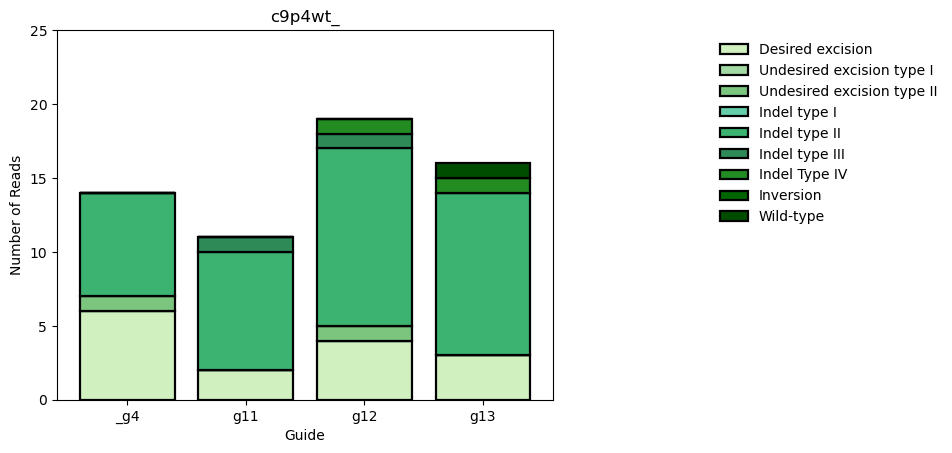

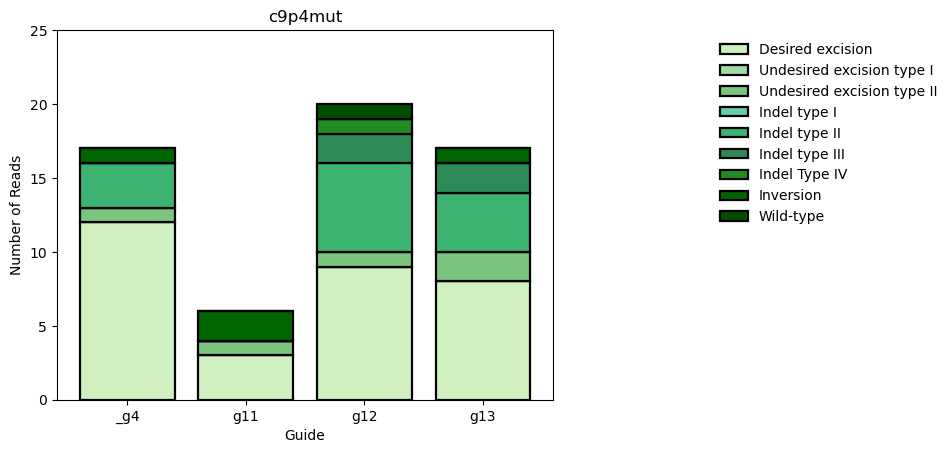

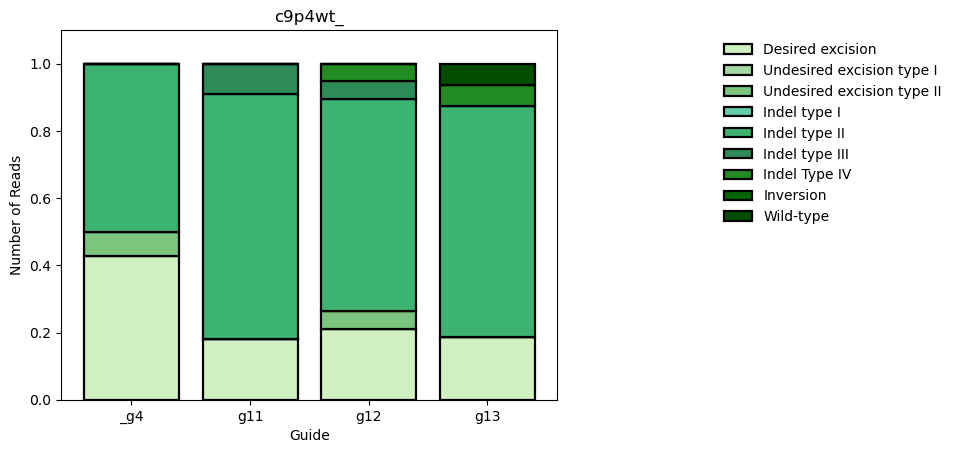

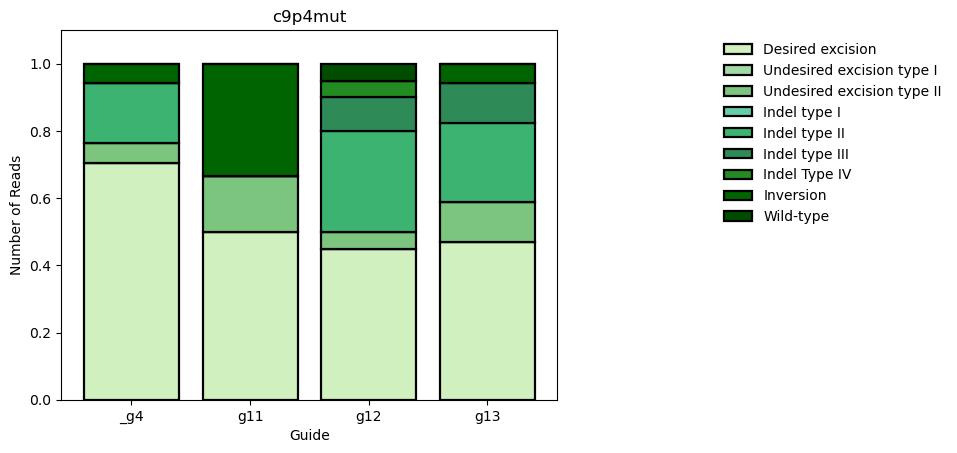

TOTAL TABLE


Group  \
Guide Allele                                                      
_g4   mut     c9p5_mut_g4c9p5_mut_g4c9p5_mut_g4c9p5_mut_g4c9...   
      wt_     c9p5_wt_g4c9p5_wt_g4c9p5_wt_g4c9p5_wt_g4c9p5_w...   
g11   mut     c9p5_mut_g11c9p5_mut_g11c9p5_mut_g11c9p5_mut_g...   
      wt_     c9p5_wt_g11c9p5_wt_g11c9p5_wt_g11c9p5_wt_g11c9...   
g12   mut     c9p5_mut_g12c9p5_mut_g12c9p5_mut_g12c9p5_mut_g...   
      wt_     c9p5_wt_g12c9p5_wt_g12c9p5_wt_g12c9p5_wt_g12c9...   
g13   mut     c9p5_mut_g13c9p5_mut_g13c9p5_mut_g13c9p5_mut_g...   
      wt_     c9p5_wt_g13c9p5_wt_g13c9p5_wt_g13c9p5_wt_g13c9...   

                                                           Name  \
Guide Allele                                                      
_g4   mut     m84127_240802_194716_s2/124260316/ccsm84127_24...   
      wt_     m84127_240802_194716_s2/147588847/ccsm84127_24...   
g11   mut     m84127_240802_194716_s2/91030239/ccsm84127_240...   
      wt_     m84127_240802_194716_s2/218432833/ccsm84127_24...   
g12   mut     m84127_240712_175808_s4/45553173/ccsm84127_240...   
      wt_     m84127_240712_175808_s4/175572092/ccsm84127_24...   
g13   mut     m84127_240802_194716_s2/228266578/ccsm84127_24...   
      wt_     m84127_240802_194716_s2/197461583/ccsm84127_24...   

             Desired excision Undesired excision type I  \
Guide Allele                                              
_g4   mut                   8                         0   
      wt_                   9                         0   
g11   mut                   6                         0   
      wt_                   4                         0   
g12   mut                   2                         0   
      wt_                   2                         0   
g13   mut                   3                         1   
      wt_                   1                         0   

             Undesired excision type II Indel type I Indel type II  \
Guide Allele                                                         
_g4   mut                             2            0             1   
      wt_                             0            0             2   
g11   mut                             0            0             3   
      wt_                             0            0             9   
g12   mut                             0            0             2   
      wt_                             0            0             3   
g13   mut                             1            0             3   
      wt_                             0            0             6   

             Indel type III Indel Type IV Inversion Wild-type Cell Line Guide  \
Guide Allele                                                                    
_g4   mut                 1             0         5         0      c9p5   _g4   
      wt_                 1             0         0         0      c9p5   _g4   
g11   mut                 1             0         3         0      c9p5   g11   
      wt_                 0             1         0         0      c9p5   g11   
g12   mut                 1             0         1         1      c9p5   g12   
      wt_                 1             0         0         0      c9p5   g12   
g13   mut                 0             0         1         0      c9p5   g13   
      wt_                 0             0         0         0      c9p5   g13   

             Allele  
Guide Allele         
_g4   mut       mut  
      wt_       wt_  
g11   mut       mut  
      wt_       wt_  
g12   mut       mut  
      wt_       wt_  
g13   mut       mut  
      wt_       wt_

sums, then tables!


,,Group,Name,Desired excision,Undesired excision type I,Undesired excision type II,Indel type I,Indel type II,Indel type III,Indel Type IV,Inversion,Wild-type,Cell Line,Guide,Allele
Guide,Allele,,,,,,,,,,,,,,
_g4,wt_,c9p5_wt_g4c9p5_wt_g4c9p5_wt_g4c9p5_wt_g4c9p5_w...,m84127_240802_194716_s2/147588847/ccsm84127_24...,9,0,0,0,2,1,0,0,0,c9p5,_g4,wt_
g11,wt_,c9p5_wt_g11c9p5_wt_g11c9p5_wt_g11c9p5_wt_g11c9...,m84127_240802_194716_s2/218432833/ccsm84127_24...,4,0,0,0,9,0,1,0,0,c9p5,g11,wt_
g12,wt_,c9p5_wt_g12c9p5_wt_g12c9p5_wt_g12c9p5_wt_g12c9...,m84127_240712_175808_s4/175572092/ccsm84127_24...,2,0,0,0,3,1,0,0,0,c9p5,g12,wt_
g13,wt_,c9p5_wt_g13c9p5_wt_g13c9p5_wt_g13c9p5_wt_g13c9...,m84127_240802_194716_s2/197461583/ccsm84127_24...,1,0,0,0,6,0,0,0,0,c9p5,g13,wt_


,,Group,Name,Desired excision,Undesired excision type I,Undesired excision type II,Indel type I,Indel type II,Indel type III,Indel Type IV,Inversion,Wild-type,Cell Line,Guide,Allele
Guide,Allele,,,,,,,,,,,,,,
_g4,mut,c9p5_mut_g4c9p5_mut_g4c9p5_mut_g4c9p5_mut_g4c9...,m84127_240802_194716_s2/124260316/ccsm84127_24...,8,0,2,0,1,1,0,5,0,c9p5,_g4,mut
g11,mut,c9p5_mut_g11c9p5_mut_g11c9p5_mut_g11c9p5_mut_g...,m84127_240802_194716_s2/91030239/ccsm84127_240...,6,0,0,0,3,1,0,3,0,c9p5,g11,mut
g12,mut,c9p5_mut_g12c9p5_mut_g12c9p5_mut_g12c9p5_mut_g...,m84127_240712_175808_s4/45553173/ccsm84127_240...,2,0,0,0,2,1,0,1,1,c9p5,g12,mut
g13,mut,c9p5_mut_g13c9p5_mut_g13c9p5_mut_g13c9p5_mut_g...,m84127_240802_194716_s2/228266578/ccsm84127_24...,3,1,1,0,3,0,0,1,0,c9p5,g13,mut


here!


Guide  Allele
_g4    wt_       12
g11    wt_       14
g12    wt_        6
g13    wt_        7
dtype: object

Guide  Allele
_g4    mut       17
g11    mut       13
g12    mut        7
g13    mut        9
dtype: object

,,Group,Name,Desired excision,Undesired excision type I,Undesired excision type II,Indel type I,Indel type II,Indel type III,Indel Type IV,Inversion,Wild-type,Cell Line,Guide,Allele
Guide,Allele,,,,,,,,,,,,,,
_g4,wt_,c9p5_wt_g4c9p5_wt_g4c9p5_wt_g4c9p5_wt_g4c9p5_w...,m84127_240802_194716_s2/147588847/ccsm84127_24...,9,0,0,0,2,1,0,0,0,c9p5,_g4,wt_
g11,wt_,c9p5_wt_g11c9p5_wt_g11c9p5_wt_g11c9p5_wt_g11c9...,m84127_240802_194716_s2/218432833/ccsm84127_24...,4,0,0,0,9,0,1,0,0,c9p5,g11,wt_
g12,wt_,c9p5_wt_g12c9p5_wt_g12c9p5_wt_g12c9p5_wt_g12c9...,m84127_240712_175808_s4/175572092/ccsm84127_24...,2,0,0,0,3,1,0,0,0,c9p5,g12,wt_
g13,wt_,c9p5_wt_g13c9p5_wt_g13c9p5_wt_g13c9p5_wt_g13c9...,m84127_240802_194716_s2/197461583/ccsm84127_24...,1,0,0,0,6,0,0,0,0,c9p5,g13,wt_


,,Group,Name,Desired excision,Undesired excision type I,Undesired excision type II,Indel type I,Indel type II,Indel type III,Indel Type IV,Inversion,Wild-type,Cell Line,Guide,Allele
Guide,Allele,,,,,,,,,,,,,,
_g4,mut,c9p5_mut_g4c9p5_mut_g4c9p5_mut_g4c9p5_mut_g4c9...,m84127_240802_194716_s2/124260316/ccsm84127_24...,8,0,2,0,1,1,0,5,0,c9p5,_g4,mut
g11,mut,c9p5_mut_g11c9p5_mut_g11c9p5_mut_g11c9p5_mut_g...,m84127_240802_194716_s2/91030239/ccsm84127_240...,6,0,0,0,3,1,0,3,0,c9p5,g11,mut
g12,mut,c9p5_mut_g12c9p5_mut_g12c9p5_mut_g12c9p5_mut_g...,m84127_240712_175808_s4/45553173/ccsm84127_240...,2,0,0,0,2,1,0,1,1,c9p5,g12,mut
g13,mut,c9p5_mut_g13c9p5_mut_g13c9p5_mut_g13c9p5_mut_g...,m84127_240802_194716_s2/228266578/ccsm84127_24...,3,1,1,0,3,0,0,1,0,c9p5,g13,mut


,,Group,Name,Desired excision,Undesired excision type I,Undesired excision type II,Indel type I,Indel type II,Indel type III,Indel Type IV,Inversion,Wild-type,Cell Line,Guide,Allele
Guide,Allele,,,,,,,,,,,,,,
_g4,wt_,c9p5_wt_g4c9p5_wt_g4c9p5_wt_g4c9p5_wt_g4c9p5_w...,m84127_240802_194716_s2/147588847/ccsm84127_24...,9,0,0,0,2,1,0,0,0,c9p5,_g4,wt_
g11,wt_,c9p5_wt_g11c9p5_wt_g11c9p5_wt_g11c9p5_wt_g11c9...,m84127_240802_194716_s2/218432833/ccsm84127_24...,4,0,0,0,9,0,1,0,0,c9p5,g11,wt_
g12,wt_,c9p5_wt_g12c9p5_wt_g12c9p5_wt_g12c9p5_wt_g12c9...,m84127_240712_175808_s4/175572092/ccsm84127_24...,2,0,0,0,3,1,0,0,0,c9p5,g12,wt_
g13,wt_,c9p5_wt_g13c9p5_wt_g13c9p5_wt_g13c9p5_wt_g13c9...,m84127_240802_194716_s2/197461583/ccsm84127_24...,1,0,0,0,6,0,0,0,0,c9p5,g13,wt_


,,Group,Name,Desired excision,Undesired excision type I,Undesired excision type II,Indel type I,Indel type II,Indel type III,Indel Type IV,Inversion,Wild-type,Cell Line,Guide,Allele
Guide,Allele,,,,,,,,,,,,,,
_g4,mut,c9p5_mut_g4c9p5_mut_g4c9p5_mut_g4c9p5_mut_g4c9...,m84127_240802_194716_s2/124260316/ccsm84127_24...,8,0,2,0,1,1,0,5,0,c9p5,_g4,mut
g11,mut,c9p5_mut_g11c9p5_mut_g11c9p5_mut_g11c9p5_mut_g...,m84127_240802_194716_s2/91030239/ccsm84127_240...,6,0,0,0,3,1,0,3,0,c9p5,g11,mut
g12,mut,c9p5_mut_g12c9p5_mut_g12c9p5_mut_g12c9p5_mut_g...,m84127_240712_175808_s4/45553173/ccsm84127_240...,2,0,0,0,2,1,0,1,1,c9p5,g12,mut
g13,mut,c9p5_mut_g13c9p5_mut_g13c9p5_mut_g13c9p5_mut_g...,m84127_240802_194716_s2/228266578/ccsm84127_24...,3,1,1,0,3,0,0,1,0,c9p5,g13,mut


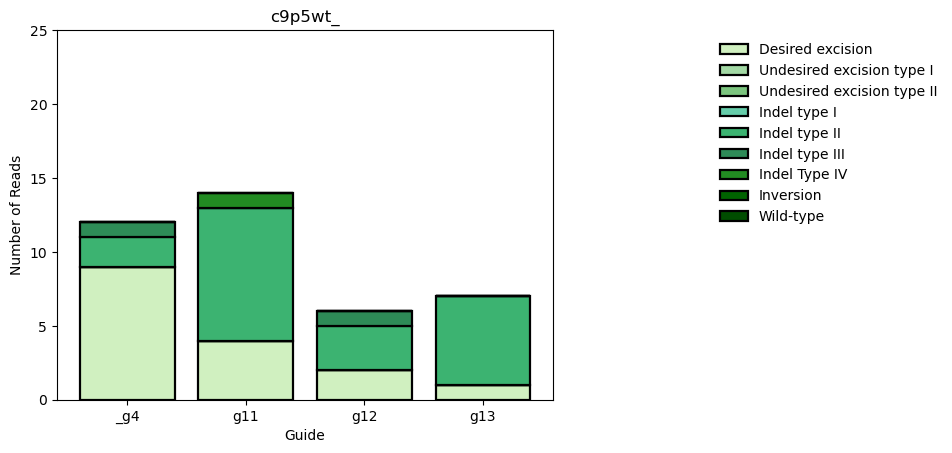

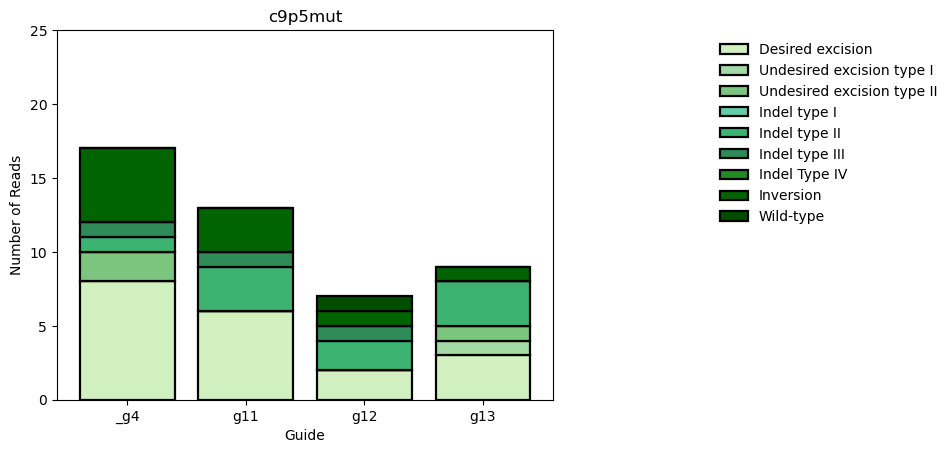

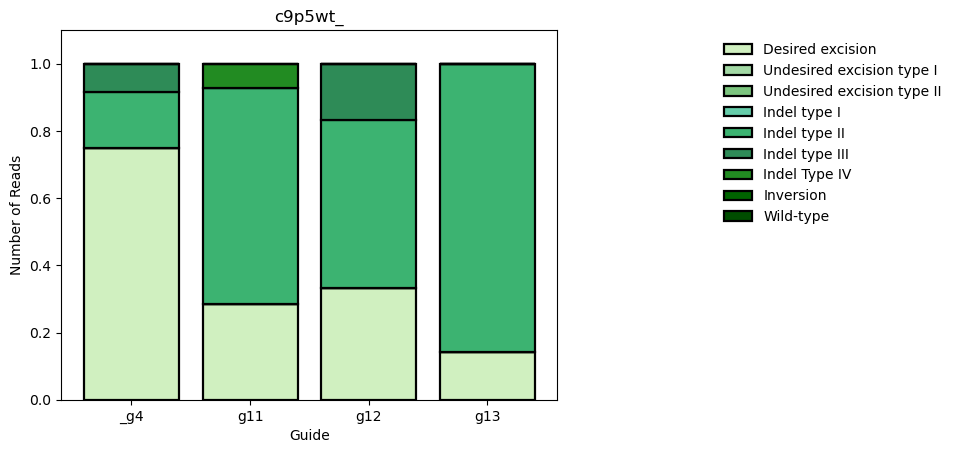

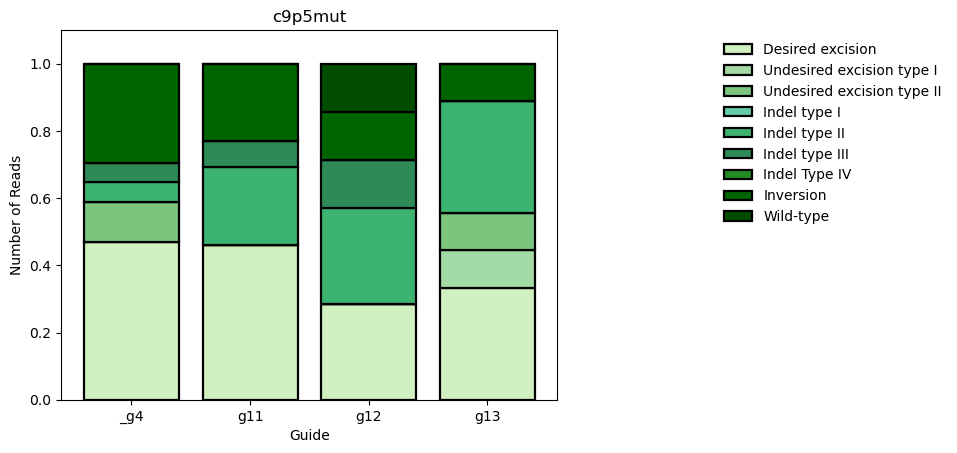

TOTAL TABLE


Group  \
Guide Allele                                                      
_g4   mut     c9p8_mut_g4c9p8_mut_g4c9p8_mut_g4c9p8_mut_g4c9...   
      wt_     c9p8_wt_g4c9p8_wt_g4c9p8_wt_g4c9p8_wt_g4c9p8_w...   
g11   mut     c9p8_mut_g11c9p8_mut_g11c9p8_mut_g11c9p8_mut_g...   
      wt_     c9p8_wt_g11c9p8_wt_g11c9p8_wt_g11c9p8_wt_g11c9...   
g12   mut     c9p8_mut_g12c9p8_mut_g12c9p8_mut_g12c9p8_mut_g...   
      wt_     c9p8_wt_g12c9p8_wt_g12c9p8_wt_g12c9p8_wt_g12c9...   
g13   mut     c9p8_mut_g13c9p8_mut_g13c9p8_mut_g13c9p8_mut_g...   
      wt_     c9p8_wt_g13c9p8_wt_g13c9p8_wt_g13c9p8_wt_g13c9...   

                                                           Name  \
Guide Allele                                                      
_g4   mut     m84127_240802_194716_s2/196678068/ccsm84127_24...   
      wt_     m84127_240802_194716_s2/183370432/ccsm84127_24...   
g11   mut     m84127_240802_194716_s2/23790670/ccsm84127_240...   
      wt_     m84127_240712_175808_s4/191498582/ccsm84127_24...   
g12   mut     m84127_240802_194716_s2/147194388/ccsm84127_24...   
      wt_     m84127_240802_194716_s2/92144969/ccsm84127_240...   
g13   mut     m84127_240802_194716_s2/21435848/ccsm84127_240...   
      wt_     m84127_240802_194716_s2/104140498/ccsm84127_24...   

             Desired excision Undesired excision type I  \
Guide Allele                                              
_g4   mut                   2                         0   
      wt_                   4                         0   
g11   mut                   5                         0   
      wt_                   3                         0   
g12   mut                   8                         0   
      wt_                   7                         0   
g13   mut                   7                         1   
      wt_                   3                         0   

             Undesired excision type II Indel type I Indel type II  \
Guide Allele                                                         
_g4   mut                             1            0             1   
      wt_                             1            0             1   
g11   mut                             0            0             1   
      wt_                             0            0             6   
g12   mut                             0            0             1   
      wt_                             1            1            13   
g13   mut                             2            1             2   
      wt_                             0            0            11   

             Indel type III Indel Type IV Inversion Wild-type Cell Line Guide  \
Guide Allele                                                                    
_g4   mut                 2             0         0         0      c9p8   _g4   
      wt_                 0             0         0         0      c9p8   _g4   
g11   mut                 0             1         0         0      c9p8   g11   
      wt_                 0             0         0         0      c9p8   g11   
g12   mut                 2             0         0         1      c9p8   g12   
      wt_                 0             0         0         0      c9p8   g12   
g13   mut                 0             0         0         1      c9p8   g13   
      wt_                 1             0         0         0      c9p8   g13   

             Allele  
Guide Allele         
_g4   mut       mut  
      wt_       wt_  
g11   mut       mut  
      wt_       wt_  
g12   mut       mut  
      wt_       wt_  
g13   mut       mut  
      wt_       wt_

sums, then tables!


,,Group,Name,Desired excision,Undesired excision type I,Undesired excision type II,Indel type I,Indel type II,Indel type III,Indel Type IV,Inversion,Wild-type,Cell Line,Guide,Allele
Guide,Allele,,,,,,,,,,,,,,
_g4,wt_,c9p8_wt_g4c9p8_wt_g4c9p8_wt_g4c9p8_wt_g4c9p8_w...,m84127_240802_194716_s2/183370432/ccsm84127_24...,4,0,1,0,1,0,0,0,0,c9p8,_g4,wt_
g11,wt_,c9p8_wt_g11c9p8_wt_g11c9p8_wt_g11c9p8_wt_g11c9...,m84127_240712_175808_s4/191498582/ccsm84127_24...,3,0,0,0,6,0,0,0,0,c9p8,g11,wt_
g12,wt_,c9p8_wt_g12c9p8_wt_g12c9p8_wt_g12c9p8_wt_g12c9...,m84127_240802_194716_s2/92144969/ccsm84127_240...,7,0,1,1,13,0,0,0,0,c9p8,g12,wt_
g13,wt_,c9p8_wt_g13c9p8_wt_g13c9p8_wt_g13c9p8_wt_g13c9...,m84127_240802_194716_s2/104140498/ccsm84127_24...,3,0,0,0,11,1,0,0,0,c9p8,g13,wt_


,,Group,Name,Desired excision,Undesired excision type I,Undesired excision type II,Indel type I,Indel type II,Indel type III,Indel Type IV,Inversion,Wild-type,Cell Line,Guide,Allele
Guide,Allele,,,,,,,,,,,,,,
_g4,mut,c9p8_mut_g4c9p8_mut_g4c9p8_mut_g4c9p8_mut_g4c9...,m84127_240802_194716_s2/196678068/ccsm84127_24...,2,0,1,0,1,2,0,0,0,c9p8,_g4,mut
g11,mut,c9p8_mut_g11c9p8_mut_g11c9p8_mut_g11c9p8_mut_g...,m84127_240802_194716_s2/23790670/ccsm84127_240...,5,0,0,0,1,0,1,0,0,c9p8,g11,mut
g12,mut,c9p8_mut_g12c9p8_mut_g12c9p8_mut_g12c9p8_mut_g...,m84127_240802_194716_s2/147194388/ccsm84127_24...,8,0,0,0,1,2,0,0,1,c9p8,g12,mut
g13,mut,c9p8_mut_g13c9p8_mut_g13c9p8_mut_g13c9p8_mut_g...,m84127_240802_194716_s2/21435848/ccsm84127_240...,7,1,2,1,2,0,0,0,1,c9p8,g13,mut


here!


Guide  Allele
_g4    wt_        6
g11    wt_        9
g12    wt_       22
g13    wt_       15
dtype: object

Guide  Allele
_g4    mut        6
g11    mut        7
g12    mut       12
g13    mut       14
dtype: object

,,Group,Name,Desired excision,Undesired excision type I,Undesired excision type II,Indel type I,Indel type II,Indel type III,Indel Type IV,Inversion,Wild-type,Cell Line,Guide,Allele
Guide,Allele,,,,,,,,,,,,,,
_g4,wt_,c9p8_wt_g4c9p8_wt_g4c9p8_wt_g4c9p8_wt_g4c9p8_w...,m84127_240802_194716_s2/183370432/ccsm84127_24...,4,0,1,0,1,0,0,0,0,c9p8,_g4,wt_
g11,wt_,c9p8_wt_g11c9p8_wt_g11c9p8_wt_g11c9p8_wt_g11c9...,m84127_240712_175808_s4/191498582/ccsm84127_24...,3,0,0,0,6,0,0,0,0,c9p8,g11,wt_
g12,wt_,c9p8_wt_g12c9p8_wt_g12c9p8_wt_g12c9p8_wt_g12c9...,m84127_240802_194716_s2/92144969/ccsm84127_240...,7,0,1,1,13,0,0,0,0,c9p8,g12,wt_
g13,wt_,c9p8_wt_g13c9p8_wt_g13c9p8_wt_g13c9p8_wt_g13c9...,m84127_240802_194716_s2/104140498/ccsm84127_24...,3,0,0,0,11,1,0,0,0,c9p8,g13,wt_


,,Group,Name,Desired excision,Undesired excision type I,Undesired excision type II,Indel type I,Indel type II,Indel type III,Indel Type IV,Inversion,Wild-type,Cell Line,Guide,Allele
Guide,Allele,,,,,,,,,,,,,,
_g4,mut,c9p8_mut_g4c9p8_mut_g4c9p8_mut_g4c9p8_mut_g4c9...,m84127_240802_194716_s2/196678068/ccsm84127_24...,2,0,1,0,1,2,0,0,0,c9p8,_g4,mut
g11,mut,c9p8_mut_g11c9p8_mut_g11c9p8_mut_g11c9p8_mut_g...,m84127_240802_194716_s2/23790670/ccsm84127_240...,5,0,0,0,1,0,1,0,0,c9p8,g11,mut
g12,mut,c9p8_mut_g12c9p8_mut_g12c9p8_mut_g12c9p8_mut_g...,m84127_240802_194716_s2/147194388/ccsm84127_24...,8,0,0,0,1,2,0,0,1,c9p8,g12,mut
g13,mut,c9p8_mut_g13c9p8_mut_g13c9p8_mut_g13c9p8_mut_g...,m84127_240802_194716_s2/21435848/ccsm84127_240...,7,1,2,1,2,0,0,0,1,c9p8,g13,mut


,,Group,Name,Desired excision,Undesired excision type I,Undesired excision type II,Indel type I,Indel type II,Indel type III,Indel Type IV,Inversion,Wild-type,Cell Line,Guide,Allele
Guide,Allele,,,,,,,,,,,,,,
_g4,wt_,c9p8_wt_g4c9p8_wt_g4c9p8_wt_g4c9p8_wt_g4c9p8_w...,m84127_240802_194716_s2/183370432/ccsm84127_24...,4,0,1,0,1,0,0,0,0,c9p8,_g4,wt_
g11,wt_,c9p8_wt_g11c9p8_wt_g11c9p8_wt_g11c9p8_wt_g11c9...,m84127_240712_175808_s4/191498582/ccsm84127_24...,3,0,0,0,6,0,0,0,0,c9p8,g11,wt_
g12,wt_,c9p8_wt_g12c9p8_wt_g12c9p8_wt_g12c9p8_wt_g12c9...,m84127_240802_194716_s2/92144969/ccsm84127_240...,7,0,1,1,13,0,0,0,0,c9p8,g12,wt_
g13,wt_,c9p8_wt_g13c9p8_wt_g13c9p8_wt_g13c9p8_wt_g13c9...,m84127_240802_194716_s2/104140498/ccsm84127_24...,3,0,0,0,11,1,0,0,0,c9p8,g13,wt_


,,Group,Name,Desired excision,Undesired excision type I,Undesired excision type II,Indel type I,Indel type II,Indel type III,Indel Type IV,Inversion,Wild-type,Cell Line,Guide,Allele
Guide,Allele,,,,,,,,,,,,,,
_g4,mut,c9p8_mut_g4c9p8_mut_g4c9p8_mut_g4c9p8_mut_g4c9...,m84127_240802_194716_s2/196678068/ccsm84127_24...,2,0,1,0,1,2,0,0,0,c9p8,_g4,mut
g11,mut,c9p8_mut_g11c9p8_mut_g11c9p8_mut_g11c9p8_mut_g...,m84127_240802_194716_s2/23790670/ccsm84127_240...,5,0,0,0,1,0,1,0,0,c9p8,g11,mut
g12,mut,c9p8_mut_g12c9p8_mut_g12c9p8_mut_g12c9p8_mut_g...,m84127_240802_194716_s2/147194388/ccsm84127_24...,8,0,0,0,1,2,0,0,1,c9p8,g12,mut
g13,mut,c9p8_mut_g13c9p8_mut_g13c9p8_mut_g13c9p8_mut_g...,m84127_240802_194716_s2/21435848/ccsm84127_240...,7,1,2,1,2,0,0,0,1,c9p8,g13,mut


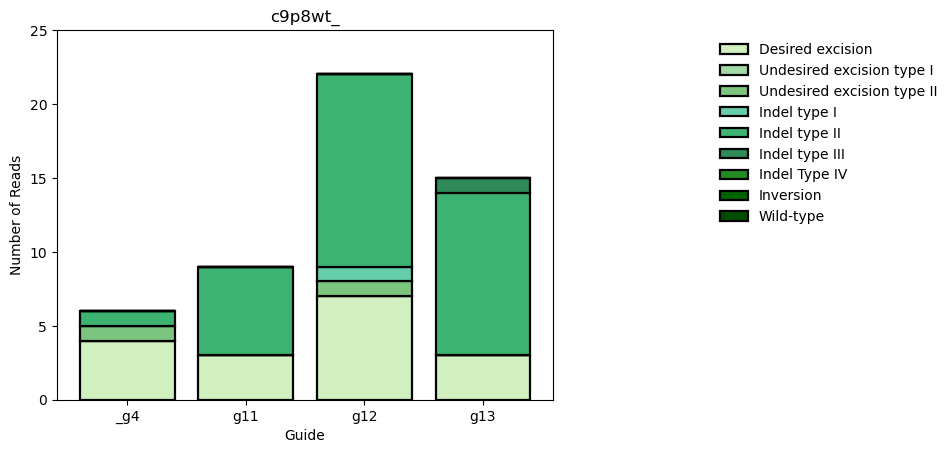

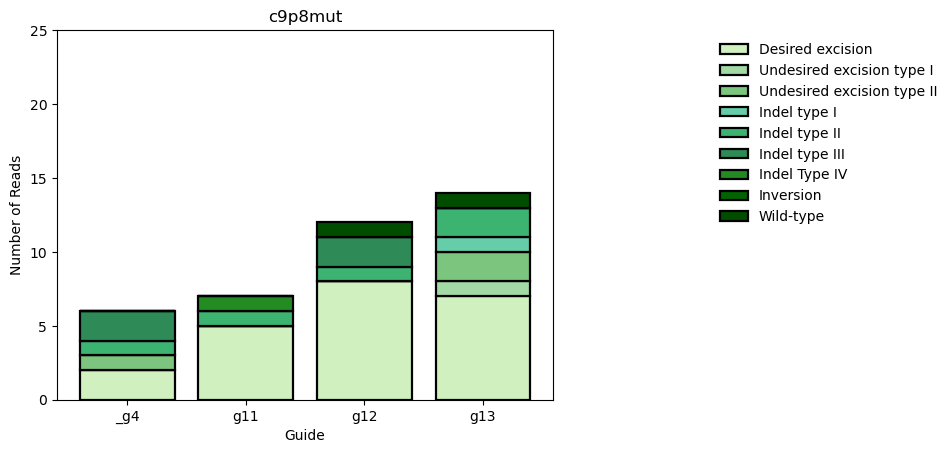

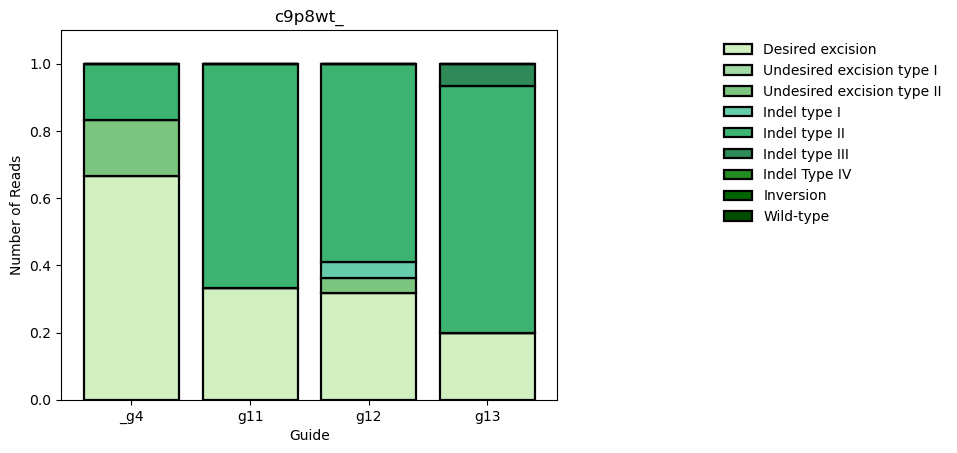

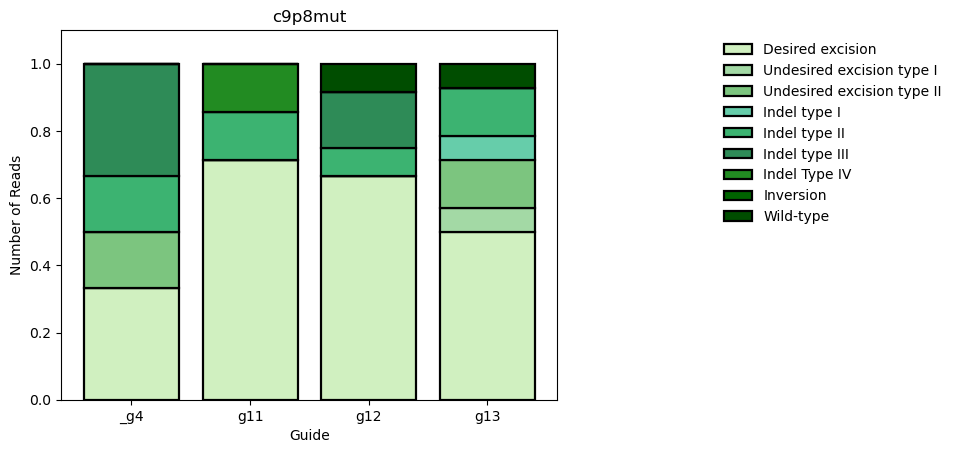

TOTAL TABLE


Group  \
Guide Allele                                                      
_g4   mut          c9p9_mut_g4c9p9_mut_g4c9p9_mut_g4c9p9_mut_g4   
      wt_                        c9p9_wt_g4c9p9_wt_g4c9p9_wt_g4   
g11   mut      c9p9_mut_g11c9p9_mut_g11c9p9_mut_g11c9p9_mut_g11   
      wt_     c9p9_wt_g11c9p9_wt_g11c9p9_wt_g11c9p9_wt_g11c9...   
g12   mut     c9p9_mut_g12c9p9_mut_g12c9p9_mut_g12c9p9_mut_g...   
      wt_                                           c9p9_wt_g12   
g13   mut                              c9p9_mut_g13c9p9_mut_g13   

                                                           Name  \
Guide Allele                                                      
_g4   mut     m84127_240802_194716_s2/53415930/ccsm84127_240...   
      wt_     m84127_240802_191544_s1/111938083/ccsm84127_24...   
g11   mut     m84127_240802_191544_s1/46268837/ccsm84127_240...   
      wt_     m84127_240802_191544_s1/190515966/ccsm84127_24...   
g12   mut     m84127_240802_194716_s2/208077170/ccsm84127_24...   
      wt_                  m84127_240802_191544_s1/82643417/ccs   
g13   mut     m84127_240802_191544_s1/247796743/ccsm84127_24...   

             Desired excision Undesired excision type I  \
Guide Allele                                              
_g4   mut                   3                         0   
      wt_                   2                         0   
g11   mut                   2                         0   
      wt_                   1                         0   
g12   mut                   4                         0   
      wt_                   0                         0   
g13   mut                   1                         0   

             Undesired excision type II Indel type I Indel type II  \
Guide Allele                                                         
_g4   mut                             0            0             0   
      wt_                             0            0             1   
g11   mut                             1            0             1   
      wt_                             0            0             3   
g12   mut                             2            0             1   
      wt_                             0            0             1   
g13   mut                             0            0             1   

             Indel type III Indel Type IV Inversion Wild-type Cell Line Guide  \
Guide Allele                                                                    
_g4   mut                 0             1         0         0      c9p9   _g4   
      wt_                 0             0         0         0      c9p9   _g4   
g11   mut                 0             0         0         0      c9p9   g11   
      wt_                 1             1         0         0      c9p9   g11   
g12   mut                 0             0         0         1      c9p9   g12   
      wt_                 0             0         0         0      c9p9   g12   
g13   mut                 0             0         0         0      c9p9   g13   

             Allele  
Guide Allele         
_g4   mut       mut  
      wt_       wt_  
g11   mut       mut  
      wt_       wt_  
g12   mut       mut  
      wt_       wt_  
g13   mut       mut

sums, then tables!


,,Group,Name,Desired excision,Undesired excision type I,Undesired excision type II,Indel type I,Indel type II,Indel type III,Indel Type IV,Inversion,Wild-type,Cell Line,Guide,Allele
Guide,Allele,,,,,,,,,,,,,,
_g4,wt_,c9p9_wt_g4c9p9_wt_g4c9p9_wt_g4,m84127_240802_191544_s1/111938083/ccsm84127_24...,2,0,0,0,1,0,0,0,0,c9p9,_g4,wt_
g11,wt_,c9p9_wt_g11c9p9_wt_g11c9p9_wt_g11c9p9_wt_g11c9...,m84127_240802_191544_s1/190515966/ccsm84127_24...,1,0,0,0,3,1,1,0,0,c9p9,g11,wt_
g12,wt_,c9p9_wt_g12,m84127_240802_191544_s1/82643417/ccs,0,0,0,0,1,0,0,0,0,c9p9,g12,wt_


,,Group,Name,Desired excision,Undesired excision type I,Undesired excision type II,Indel type I,Indel type II,Indel type III,Indel Type IV,Inversion,Wild-type,Cell Line,Guide,Allele
Guide,Allele,,,,,,,,,,,,,,
_g4,mut,c9p9_mut_g4c9p9_mut_g4c9p9_mut_g4c9p9_mut_g4,m84127_240802_194716_s2/53415930/ccsm84127_240...,3,0,0,0,0,0,1,0,0,c9p9,_g4,mut
g11,mut,c9p9_mut_g11c9p9_mut_g11c9p9_mut_g11c9p9_mut_g11,m84127_240802_191544_s1/46268837/ccsm84127_240...,2,0,1,0,1,0,0,0,0,c9p9,g11,mut
g12,mut,c9p9_mut_g12c9p9_mut_g12c9p9_mut_g12c9p9_mut_g...,m84127_240802_194716_s2/208077170/ccsm84127_24...,4,0,2,0,1,0,0,0,1,c9p9,g12,mut
g13,mut,c9p9_mut_g13c9p9_mut_g13,m84127_240802_191544_s1/247796743/ccsm84127_24...,1,0,0,0,1,0,0,0,0,c9p9,g13,mut


here!


Guide  Allele
_g4    wt_       3
g11    wt_       6
g12    wt_       1
dtype: object

Guide  Allele
_g4    mut       4
g11    mut       4
g12    mut       8
g13    mut       2
dtype: object

,,Group,Name,Desired excision,Undesired excision type I,Undesired excision type II,Indel type I,Indel type II,Indel type III,Indel Type IV,Inversion,Wild-type,Cell Line,Guide,Allele
Guide,Allele,,,,,,,,,,,,,,
_g4,wt_,c9p9_wt_g4c9p9_wt_g4c9p9_wt_g4,m84127_240802_191544_s1/111938083/ccsm84127_24...,2,0,0,0,1,0,0,0,0,c9p9,_g4,wt_
g11,wt_,c9p9_wt_g11c9p9_wt_g11c9p9_wt_g11c9p9_wt_g11c9...,m84127_240802_191544_s1/190515966/ccsm84127_24...,1,0,0,0,3,1,1,0,0,c9p9,g11,wt_
g12,wt_,c9p9_wt_g12,m84127_240802_191544_s1/82643417/ccs,0,0,0,0,1,0,0,0,0,c9p9,g12,wt_


,,Group,Name,Desired excision,Undesired excision type I,Undesired excision type II,Indel type I,Indel type II,Indel type III,Indel Type IV,Inversion,Wild-type,Cell Line,Guide,Allele
Guide,Allele,,,,,,,,,,,,,,
_g4,mut,c9p9_mut_g4c9p9_mut_g4c9p9_mut_g4c9p9_mut_g4,m84127_240802_194716_s2/53415930/ccsm84127_240...,3,0,0,0,0,0,1,0,0,c9p9,_g4,mut
g11,mut,c9p9_mut_g11c9p9_mut_g11c9p9_mut_g11c9p9_mut_g11,m84127_240802_191544_s1/46268837/ccsm84127_240...,2,0,1,0,1,0,0,0,0,c9p9,g11,mut
g12,mut,c9p9_mut_g12c9p9_mut_g12c9p9_mut_g12c9p9_mut_g...,m84127_240802_194716_s2/208077170/ccsm84127_24...,4,0,2,0,1,0,0,0,1,c9p9,g12,mut
g13,mut,c9p9_mut_g13c9p9_mut_g13,m84127_240802_191544_s1/247796743/ccsm84127_24...,1,0,0,0,1,0,0,0,0,c9p9,g13,mut


,,Group,Name,Desired excision,Undesired excision type I,Undesired excision type II,Indel type I,Indel type II,Indel type III,Indel Type IV,Inversion,Wild-type,Cell Line,Guide,Allele
Guide,Allele,,,,,,,,,,,,,,
_g4,wt_,c9p9_wt_g4c9p9_wt_g4c9p9_wt_g4,m84127_240802_191544_s1/111938083/ccsm84127_24...,2,0,0,0,1,0,0,0,0,c9p9,_g4,wt_
g11,wt_,c9p9_wt_g11c9p9_wt_g11c9p9_wt_g11c9p9_wt_g11c9...,m84127_240802_191544_s1/190515966/ccsm84127_24...,1,0,0,0,3,1,1,0,0,c9p9,g11,wt_
g12,wt_,c9p9_wt_g12,m84127_240802_191544_s1/82643417/ccs,0,0,0,0,1,0,0,0,0,c9p9,g12,wt_


,,Group,Name,Desired excision,Undesired excision type I,Undesired excision type II,Indel type I,Indel type II,Indel type III,Indel Type IV,Inversion,Wild-type,Cell Line,Guide,Allele
Guide,Allele,,,,,,,,,,,,,,
_g4,mut,c9p9_mut_g4c9p9_mut_g4c9p9_mut_g4c9p9_mut_g4,m84127_240802_194716_s2/53415930/ccsm84127_240...,3,0,0,0,0,0,1,0,0,c9p9,_g4,mut
g11,mut,c9p9_mut_g11c9p9_mut_g11c9p9_mut_g11c9p9_mut_g11,m84127_240802_191544_s1/46268837/ccsm84127_240...,2,0,1,0,1,0,0,0,0,c9p9,g11,mut
g12,mut,c9p9_mut_g12c9p9_mut_g12c9p9_mut_g12c9p9_mut_g...,m84127_240802_194716_s2/208077170/ccsm84127_24...,4,0,2,0,1,0,0,0,1,c9p9,g12,mut
g13,mut,c9p9_mut_g13c9p9_mut_g13,m84127_240802_191544_s1/247796743/ccsm84127_24...,1,0,0,0,1,0,0,0,0,c9p9,g13,mut


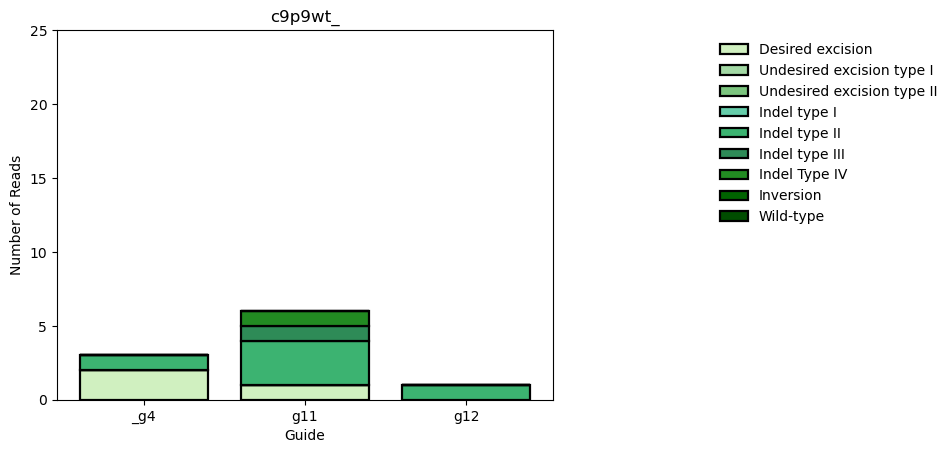

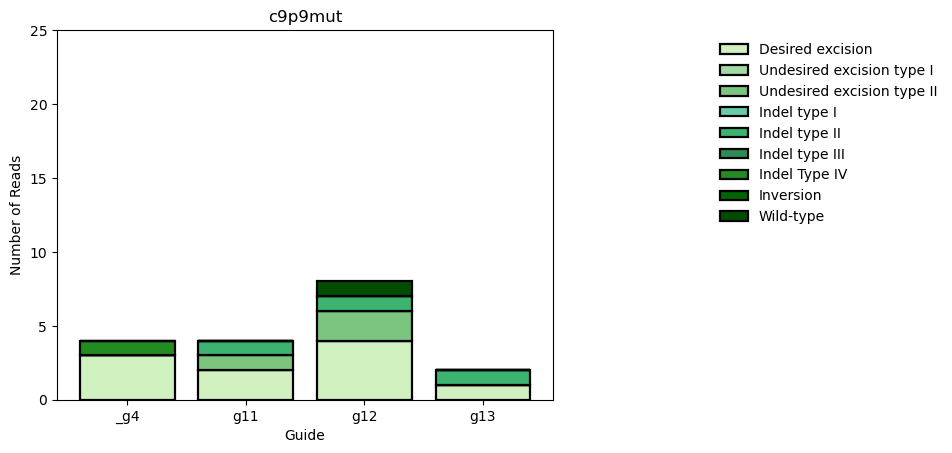

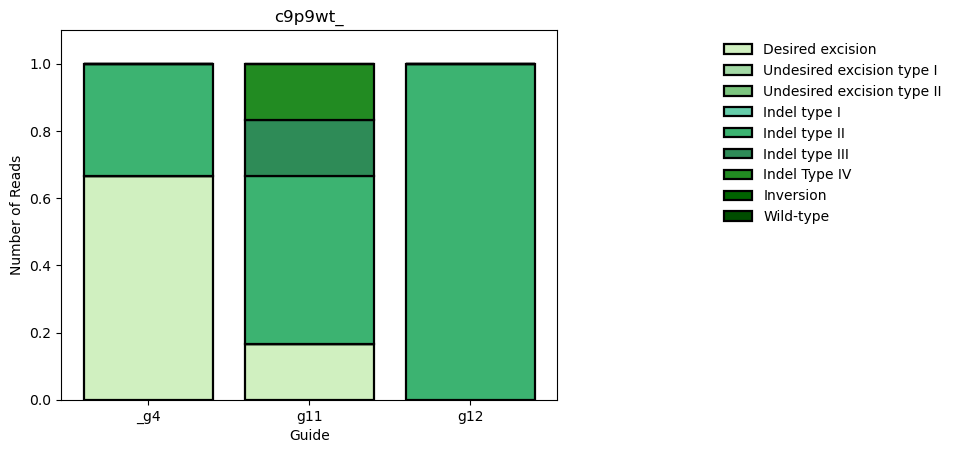

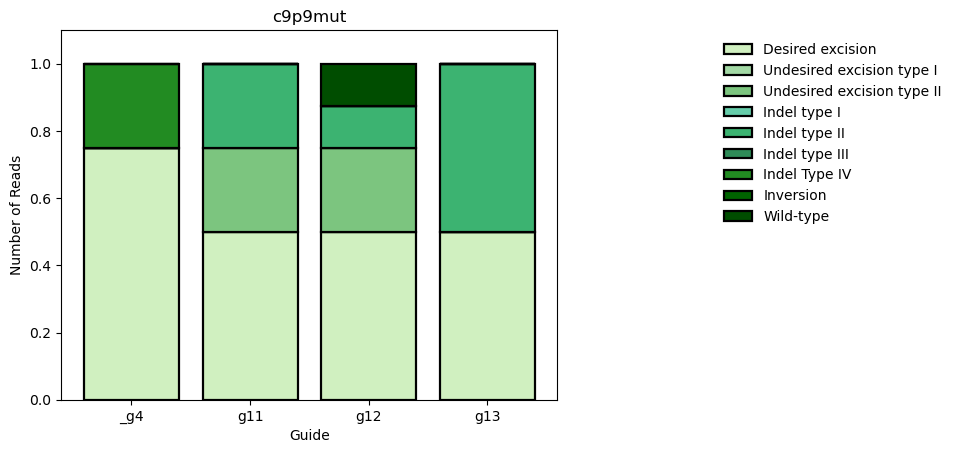

,Group,Name,Desired excision,Undesired Excision,Inversion,Indel,Wildtype,Cell Line,Guide,Allele
4,c9p4_wt_g11,m84127_240712_175808_s4/24382007/ccsm84127_240...,2,0,0,8,1,c9p4,g11,wt_
5,c9p4_wt_g12,m84127_240712_175808_s4/64623199/ccsm84127_240...,4,1,0,12,1,c9p4,g12,wt_
6,c9p4_wt_g13,m84127_240802_194716_s2/149230529/ccsm84127_24...,3,0,0,11,1,c9p4,g13,wt_
7,c9p4_wt_g4,m84127_240712_175808_s4/123800984/ccsm84127_24...,6,1,0,7,0,c9p4,_g4,wt_


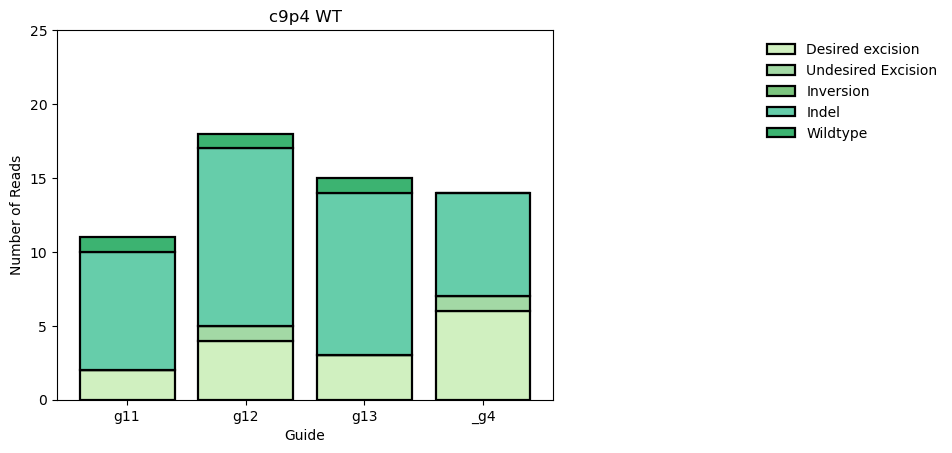

,Group,Name,Desired excision,Undesired Excision,Inversion,Indel,Wildtype,Cell Line,Guide,Allele
12,c9p5_wt_g11,m84127_240802_194716_s2/218432833/ccsm84127_24...,4,0,0,9,0,c9p5,g11,wt_
13,c9p5_wt_g12,m84127_240712_175808_s4/175572092/ccsm84127_24...,2,0,0,3,1,c9p5,g12,wt_
14,c9p5_wt_g13,m84127_240802_194716_s2/197461583/ccsm84127_24...,1,0,0,6,0,c9p5,g13,wt_
15,c9p5_wt_g4,m84127_240802_194716_s2/147588847/ccsm84127_24...,9,0,0,2,1,c9p5,_g4,wt_


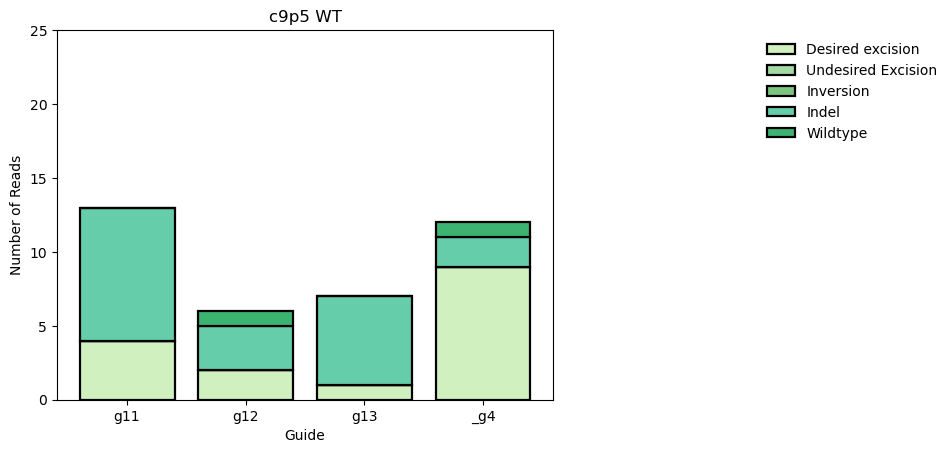

,Group,Name,Desired excision,Undesired Excision,Inversion,Indel,Wildtype,Cell Line,Guide,Allele
12,c9p5_wt_g11,m84127_240802_194716_s2/218432833/ccsm84127_24...,4,0,0,9,0,c9p5,g11,wt_
13,c9p5_wt_g12,m84127_240712_175808_s4/175572092/ccsm84127_24...,2,0,0,3,1,c9p5,g12,wt_
14,c9p5_wt_g13,m84127_240802_194716_s2/197461583/ccsm84127_24...,1,0,0,6,0,c9p5,g13,wt_
15,c9p5_wt_g4,m84127_240802_194716_s2/147588847/ccsm84127_24...,9,0,0,2,1,c9p5,_g4,wt_


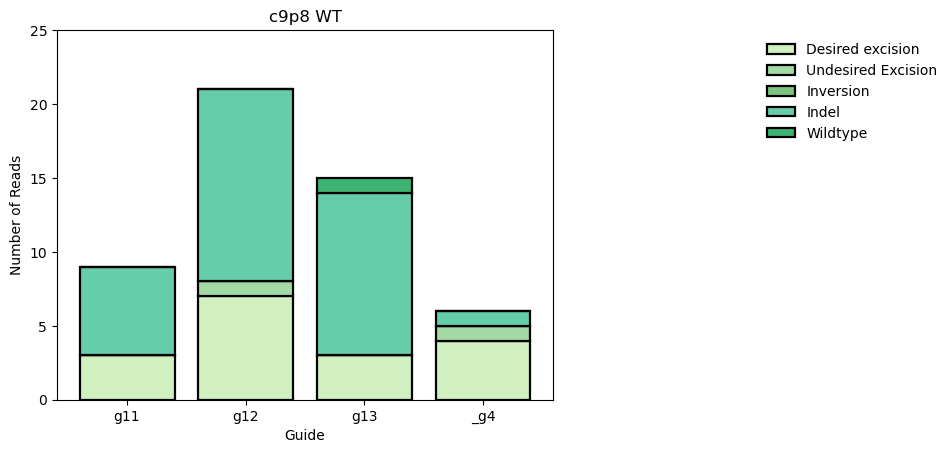

DISPLAYING C9 P9 WHOOHOO


,Group,Name,Desired excision,Undesired Excision,Inversion,Indel,Wildtype,Cell Line,Guide,Allele
28,c9p9_wt_g11,m84127_240802_191544_s1/190515966/ccsm84127_24...,1,0,0,3,1,c9p9,g11,wt_
29,c9p9_wt_g12,m84127_240802_191544_s1/82643417/ccs,0,0,0,1,0,c9p9,g12,wt_
30,c9p9_wt_g4,m84127_240802_191544_s1/111938083/ccsm84127_24...,2,0,0,1,0,c9p9,_g4,wt_


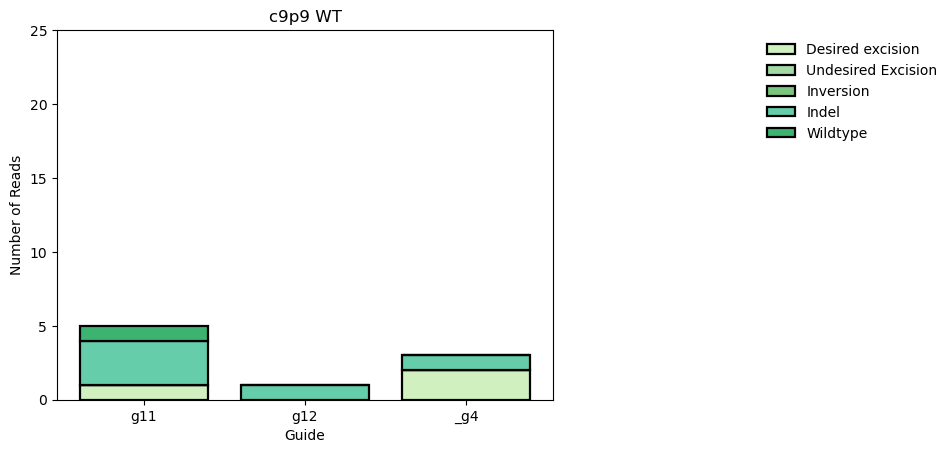

,Group,Name,Desired excision,Undesired Excision,Inversion,Indel,Wildtype,Cell Line,Guide,Allele
0,c9p4_mut_g11,m84127_240712_175808_s4/246483519/ccsm84127_24...,3,1,2,0,0,c9p4,g11,mut
1,c9p4_mut_g12,m84127_240712_175808_s4/204801393/ccsm84127_24...,9,1,0,6,3,c9p4,g12,mut
2,c9p4_mut_g13,m84127_240802_194716_s2/177998463/ccsm84127_24...,8,2,1,4,2,c9p4,g13,mut
3,c9p4_mut_g4,m84127_240802_194716_s2/58000941/ccsm84127_240...,12,1,1,3,0,c9p4,_g4,mut


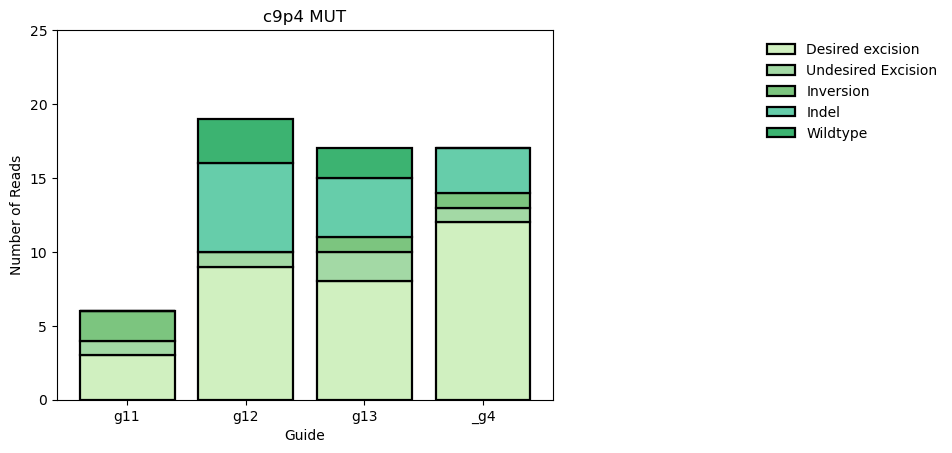

,Group,Name,Desired excision,Undesired Excision,Inversion,Indel,Wildtype,Cell Line,Guide,Allele
8,c9p5_mut_g11,m84127_240802_194716_s2/91030239/ccsm84127_240...,6,0,3,3,1,c9p5,g11,mut
9,c9p5_mut_g12,m84127_240712_175808_s4/45553173/ccsm84127_240...,2,0,1,2,2,c9p5,g12,mut
10,c9p5_mut_g13,m84127_240802_194716_s2/228266578/ccsm84127_24...,3,2,1,3,0,c9p5,g13,mut
11,c9p5_mut_g4,m84127_240802_194716_s2/124260316/ccsm84127_24...,8,2,5,1,1,c9p5,_g4,mut


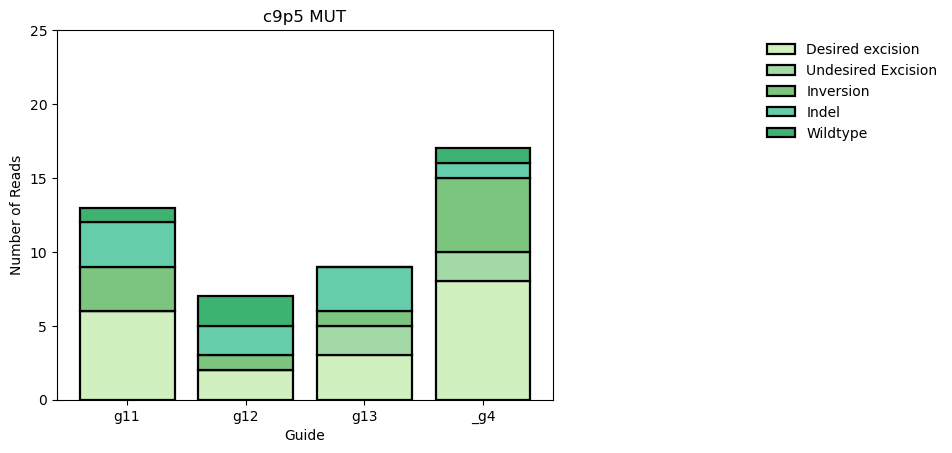

,Group,Name,Desired excision,Undesired Excision,Inversion,Indel,Wildtype,Cell Line,Guide,Allele
16,c9p8_mut_g11,m84127_240802_194716_s2/23790670/ccsm84127_240...,5,0,0,1,0,c9p8,g11,mut
17,c9p8_mut_g12,m84127_240802_194716_s2/147194388/ccsm84127_24...,8,0,0,1,3,c9p8,g12,mut
18,c9p8_mut_g13,m84127_240802_194716_s2/21435848/ccsm84127_240...,7,3,0,2,1,c9p8,g13,mut
19,c9p8_mut_g4,m84127_240802_194716_s2/196678068/ccsm84127_24...,2,1,0,1,2,c9p8,_g4,mut


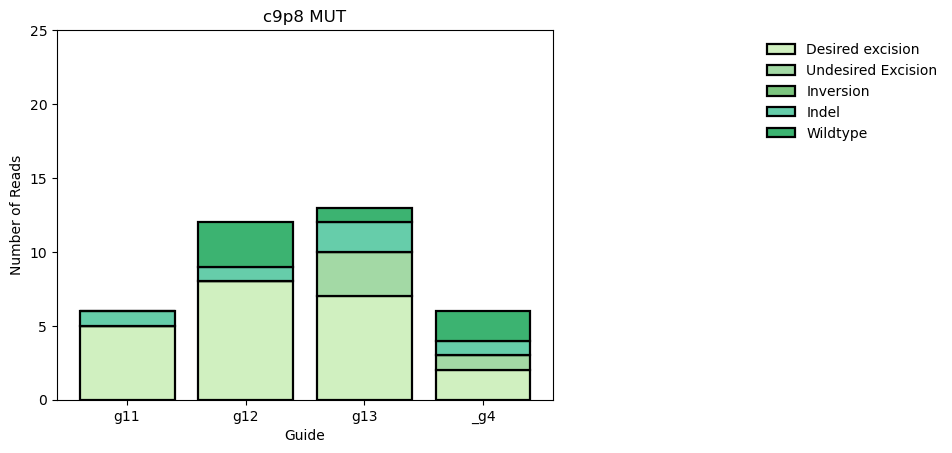

DISPLAYING C9 P9 WHOOHOO


,Group,Name,Desired excision,Undesired Excision,Inversion,Indel,Wildtype,Cell Line,Guide,Allele
24,c9p9_mut_g11,m84127_240802_191544_s1/46268837/ccsm84127_240...,2,1,0,1,0,c9p9,g11,mut
25,c9p9_mut_g12,m84127_240802_194716_s2/208077170/ccsm84127_24...,4,2,0,1,1,c9p9,g12,mut
26,c9p9_mut_g13,m84127_240802_191544_s1/247796743/ccsm84127_24...,1,0,0,1,0,c9p9,g13,mut
27,c9p9_mut_g4,m84127_240802_194716_s2/53415930/ccsm84127_240...,3,0,0,0,0,c9p9,_g4,mut


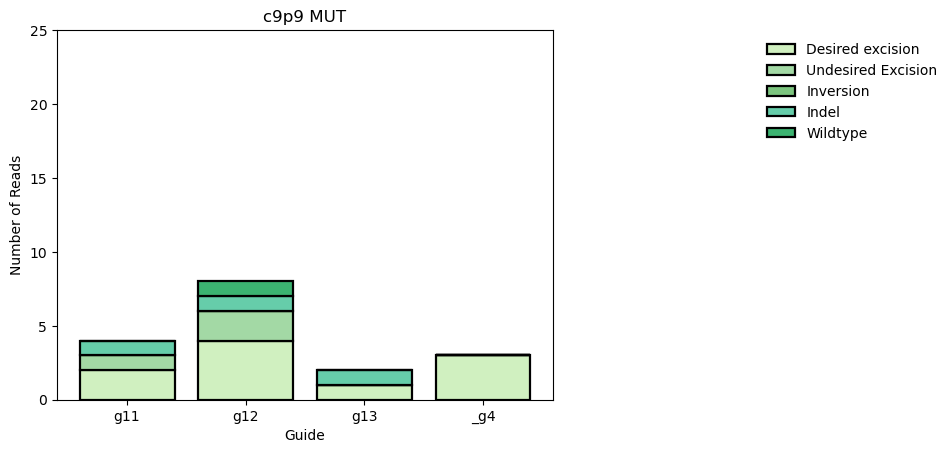

,Desired excision,Undesired Excision,Inversion,Indel,Wildtype,Group,Guide
4,0.181818,0.0,0.0,0.727273,0.090909,c9p4_wt_g11,g11
5,0.222222,0.055556,0.0,0.666667,0.055556,c9p4_wt_g12,g12
6,0.2,0.0,0.0,0.733333,0.066667,c9p4_wt_g13,g13
7,0.428571,0.071429,0.0,0.5,0.0,c9p4_wt_g4,_g4


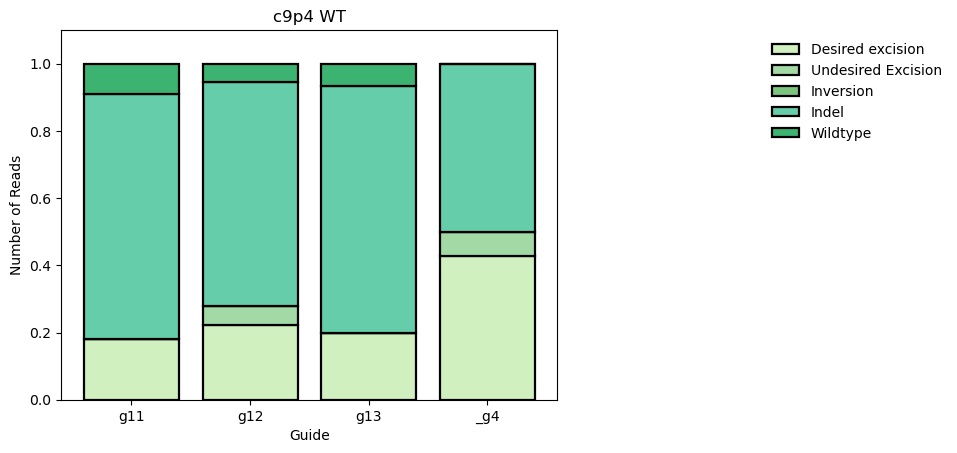

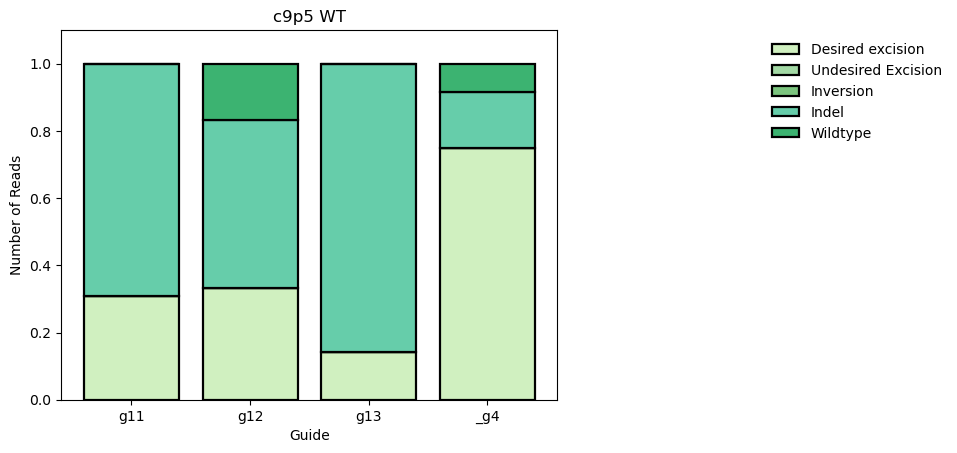

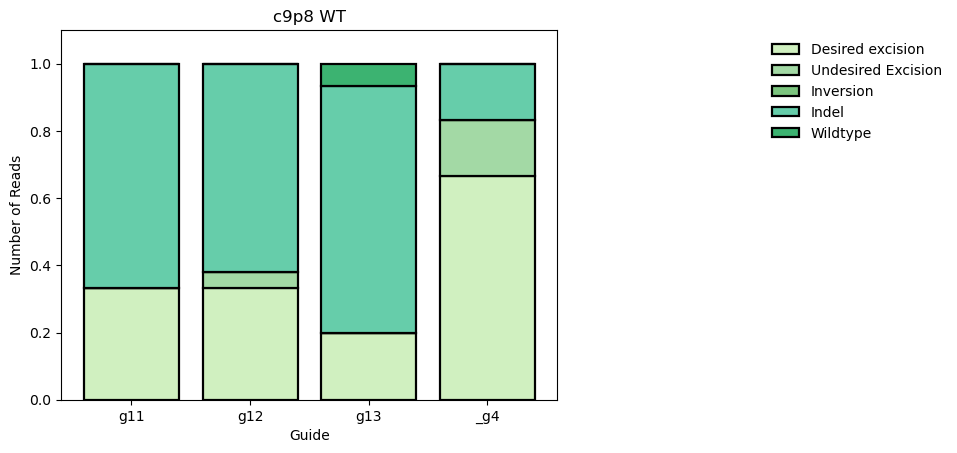

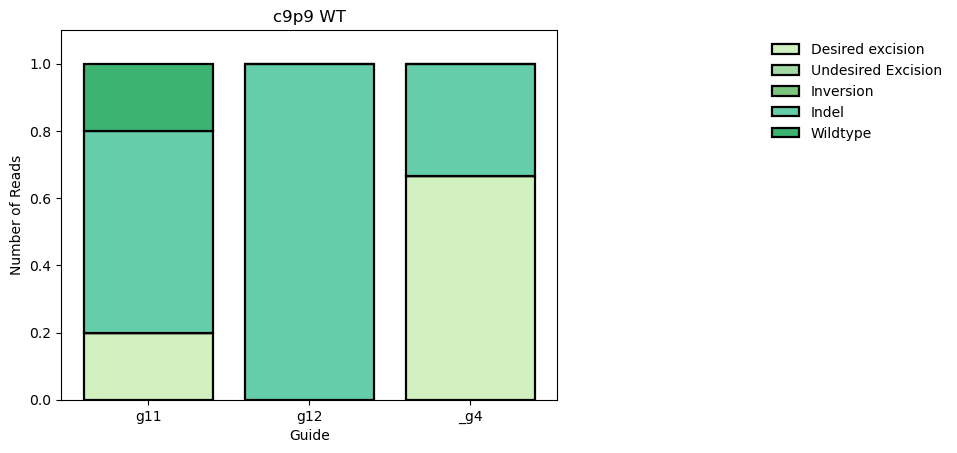

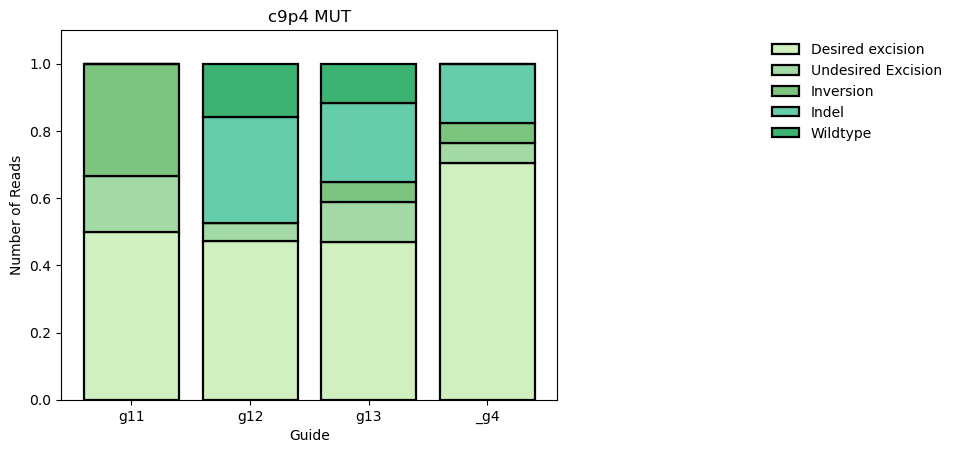

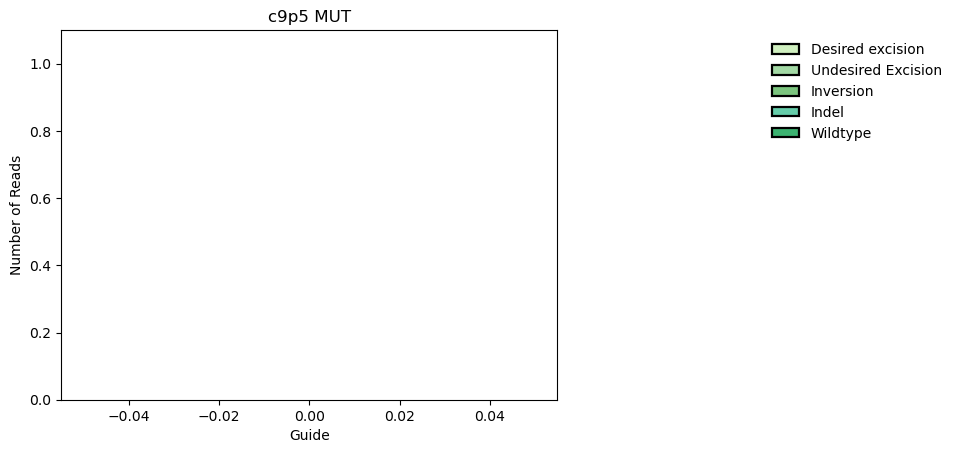

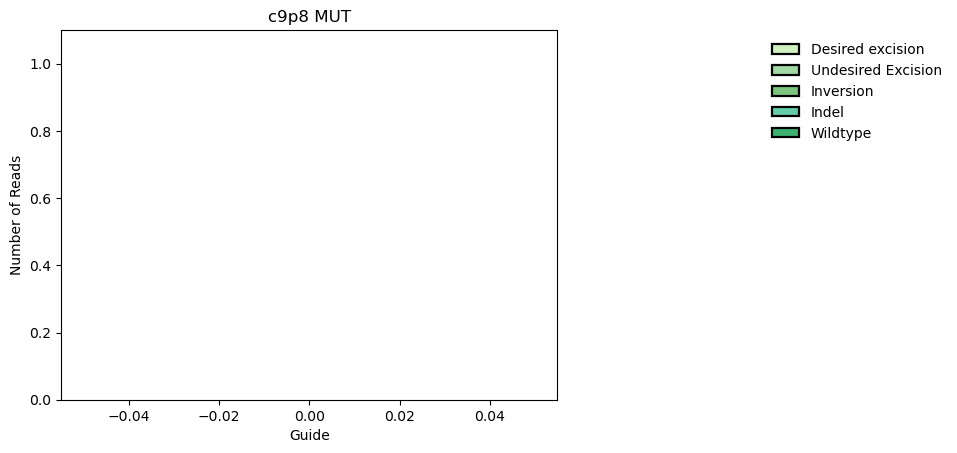

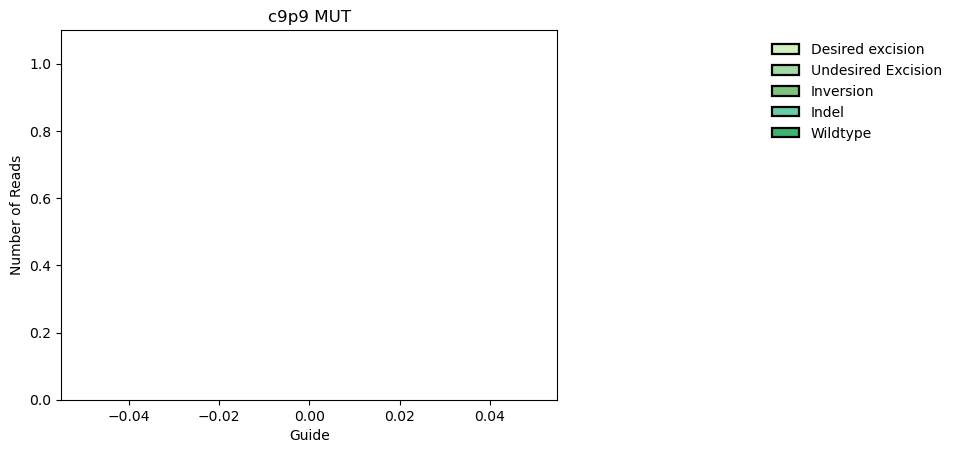

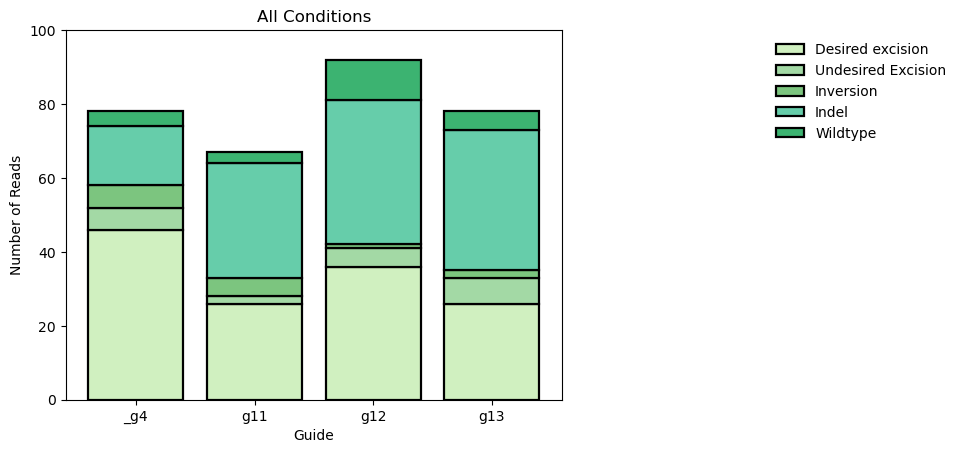

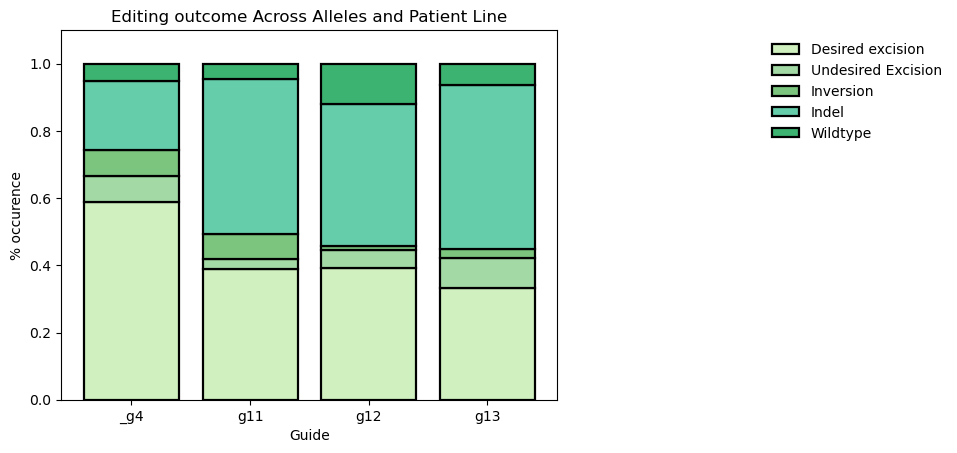

Group  \
Cell Line Allele                                                    
c9p4      mut     c9p4_mut_g11c9p4_mut_g12c9p4_mut_g13c9p4_mut_g4   
          wt_         c9p4_wt_g11c9p4_wt_g12c9p4_wt_g13c9p4_wt_g4   
c9p5      mut     c9p5_mut_g11c9p5_mut_g12c9p5_mut_g13c9p5_mut_g4   
          wt_         c9p5_wt_g11c9p5_wt_g12c9p5_wt_g13c9p5_wt_g4   
c9p8      mut     c9p8_mut_g11c9p8_mut_g12c9p8_mut_g13c9p8_mut_g4   
          wt_         c9p8_wt_g11c9p8_wt_g12c9p8_wt_g13c9p8_wt_g4   
c9p9      mut     c9p9_mut_g11c9p9_mut_g12c9p9_mut_g13c9p9_mut_g4   
          wt_                    c9p9_wt_g11c9p9_wt_g12c9p9_wt_g4   

                                                               Name  \
Cell Line Allele                                                      
c9p4      mut     m84127_240712_175808_s4/246483519/ccsm84127_24...   
          wt_     m84127_240712_175808_s4/24382007/ccsm84127_240...   
c9p5      mut     m84127_240802_194716_s2/91030239/ccsm84127_240...   
          wt_     m84127_240802_194716_s2/218432833/ccsm84127_24...   
c9p8      mut     m84127_240802_194716_s2/23790670/ccsm84127_240...   
          wt_     m84127_240712_175808_s4/191498582/ccsm84127_24...   
c9p9      mut     m84127_240802_191544_s1/46268837/ccsm84127_240...   
          wt_     m84127_240802_191544_s1/190515966/ccsm84127_24...   

                 Desired excision Undesired Excision Inversion Indel Wildtype  \
Cell Line Allele                                                                
c9p4      mut                  32                  5         4    13        5   
          wt_                  15                  2         0    38        3   
c9p5      mut                  19                  4        10     9        4   
          wt_                  16                  0         0    20        2   
c9p8      mut                  22                  4         0     5        6   
          wt_                  17                  2         0    31        1   
c9p9      mut                  10                  3         0     3        1   
          wt_                   3                  0         0     5        1   

                         Guide  
Cell Line Allele                
c9p4      mut     g11g12g13_g4  
          wt_     g11g12g13_g4  
c9p5      mut     g11g12g13_g4  
          wt_     g11g12g13_g4  
c9p8      mut     g11g12g13_g4  
          wt_     g11g12g13_g4  
c9p9      mut     g11g12g13_g4  
          wt_        g11g12_g4

,Cell Line,Allele,Group,Name,Desired excision,Undesired Excision,Inversion,Indel,Wildtype,Guide
0,c9p4,mut,c9p4_mut_g11c9p4_mut_g12c9p4_mut_g13c9p4_mut_g4,m84127_240712_175808_s4/246483519/ccsm84127_24...,32,5,4,13,5,g11g12g13_g4
1,c9p4,wt_,c9p4_wt_g11c9p4_wt_g12c9p4_wt_g13c9p4_wt_g4,m84127_240712_175808_s4/24382007/ccsm84127_240...,15,2,0,38,3,g11g12g13_g4
2,c9p5,mut,c9p5_mut_g11c9p5_mut_g12c9p5_mut_g13c9p5_mut_g4,m84127_240802_194716_s2/91030239/ccsm84127_240...,19,4,10,9,4,g11g12g13_g4
3,c9p5,wt_,c9p5_wt_g11c9p5_wt_g12c9p5_wt_g13c9p5_wt_g4,m84127_240802_194716_s2/218432833/ccsm84127_24...,16,0,0,20,2,g11g12g13_g4
4,c9p8,mut,c9p8_mut_g11c9p8_mut_g12c9p8_mut_g13c9p8_mut_g4,m84127_240802_194716_s2/23790670/ccsm84127_240...,22,4,0,5,6,g11g12g13_g4
5,c9p8,wt_,c9p8_wt_g11c9p8_wt_g12c9p8_wt_g13c9p8_wt_g4,m84127_240712_175808_s4/191498582/ccsm84127_24...,17,2,0,31,1,g11g12g13_g4
6,c9p9,mut,c9p9_mut_g11c9p9_mut_g12c9p9_mut_g13c9p9_mut_g4,m84127_240802_191544_s1/46268837/ccsm84127_240...,10,3,0,3,1,g11g12g13_g4
7,c9p9,wt_,c9p9_wt_g11c9p9_wt_g12c9p9_wt_g4,m84127_240802_191544_s1/190515966/ccsm84127_24...,3,0,0,5,1,g11g12_g4


,Cell Line,Allele,Group,Name,Desired excision,Undesired Excision,Inversion,Indel,Wildtype,Guide
0,c9p4,mut,c9p4_mut_g11c9p4_mut_g12c9p4_mut_g13c9p4_mut_g4,m84127_240712_175808_s4/246483519/ccsm84127_24...,32,5,4,13,5,g11g12g13_g4
1,c9p4,wt_,c9p4_wt_g11c9p4_wt_g12c9p4_wt_g13c9p4_wt_g4,m84127_240712_175808_s4/24382007/ccsm84127_240...,15,2,0,38,3,g11g12g13_g4


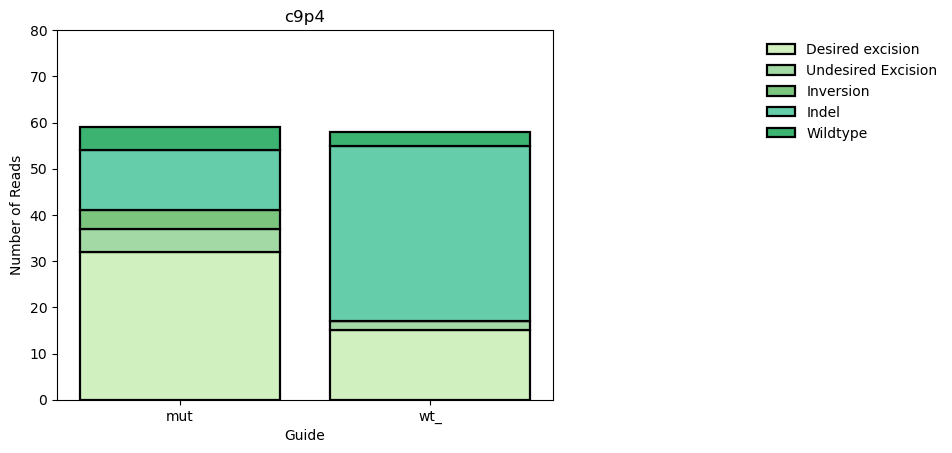

,Desired excision,Undesired Excision,Inversion,Indel,Wildtype,Allele
0,0.542373,0.084746,0.067797,0.220339,0.084746,mut
1,0.258621,0.034483,0.0,0.655172,0.051724,wt_


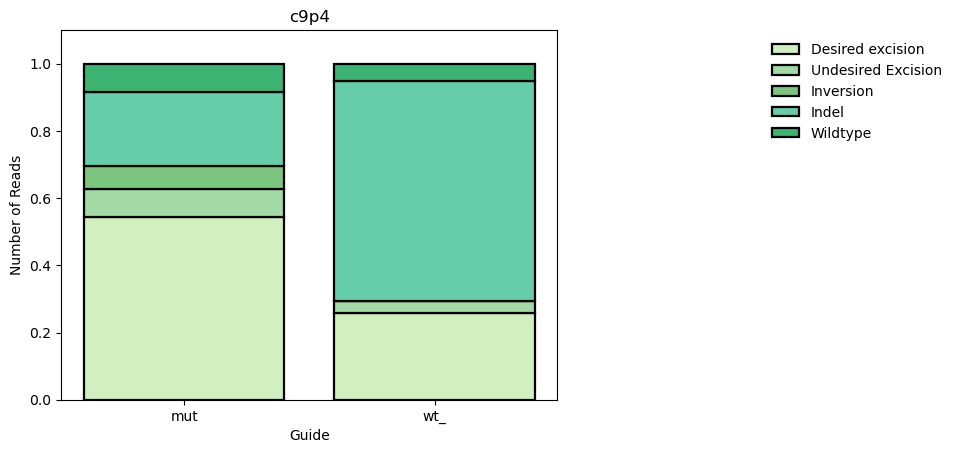

,Cell Line,Allele,Group,Name,Desired excision,Undesired Excision,Inversion,Indel,Wildtype,Guide
0,c9p4,mut,c9p4_mut_g11c9p4_mut_g12c9p4_mut_g13c9p4_mut_g4,m84127_240712_175808_s4/246483519/ccsm84127_24...,32,5,4,13,5,g11g12g13_g4
1,c9p4,wt_,c9p4_wt_g11c9p4_wt_g12c9p4_wt_g13c9p4_wt_g4,m84127_240712_175808_s4/24382007/ccsm84127_240...,15,2,0,38,3,g11g12g13_g4
2,c9p5,mut,c9p5_mut_g11c9p5_mut_g12c9p5_mut_g13c9p5_mut_g4,m84127_240802_194716_s2/91030239/ccsm84127_240...,19,4,10,9,4,g11g12g13_g4
3,c9p5,wt_,c9p5_wt_g11c9p5_wt_g12c9p5_wt_g13c9p5_wt_g4,m84127_240802_194716_s2/218432833/ccsm84127_24...,16,0,0,20,2,g11g12g13_g4
4,c9p8,mut,c9p8_mut_g11c9p8_mut_g12c9p8_mut_g13c9p8_mut_g4,m84127_240802_194716_s2/23790670/ccsm84127_240...,22,4,0,5,6,g11g12g13_g4
5,c9p8,wt_,c9p8_wt_g11c9p8_wt_g12c9p8_wt_g13c9p8_wt_g4,m84127_240712_175808_s4/191498582/ccsm84127_24...,17,2,0,31,1,g11g12g13_g4
6,c9p9,mut,c9p9_mut_g11c9p9_mut_g12c9p9_mut_g13c9p9_mut_g4,m84127_240802_191544_s1/46268837/ccsm84127_240...,10,3,0,3,1,g11g12g13_g4
7,c9p9,wt_,c9p9_wt_g11c9p9_wt_g12c9p9_wt_g4,m84127_240802_191544_s1/190515966/ccsm84127_24...,3,0,0,5,1,g11g12_g4


,Cell Line,Allele,Group,Name,Desired excision,Undesired Excision,Inversion,Indel,Wildtype,Guide
2,c9p5,mut,c9p5_mut_g11c9p5_mut_g12c9p5_mut_g13c9p5_mut_g4,m84127_240802_194716_s2/91030239/ccsm84127_240...,19,4,10,9,4,g11g12g13_g4
3,c9p5,wt_,c9p5_wt_g11c9p5_wt_g12c9p5_wt_g13c9p5_wt_g4,m84127_240802_194716_s2/218432833/ccsm84127_24...,16,0,0,20,2,g11g12g13_g4


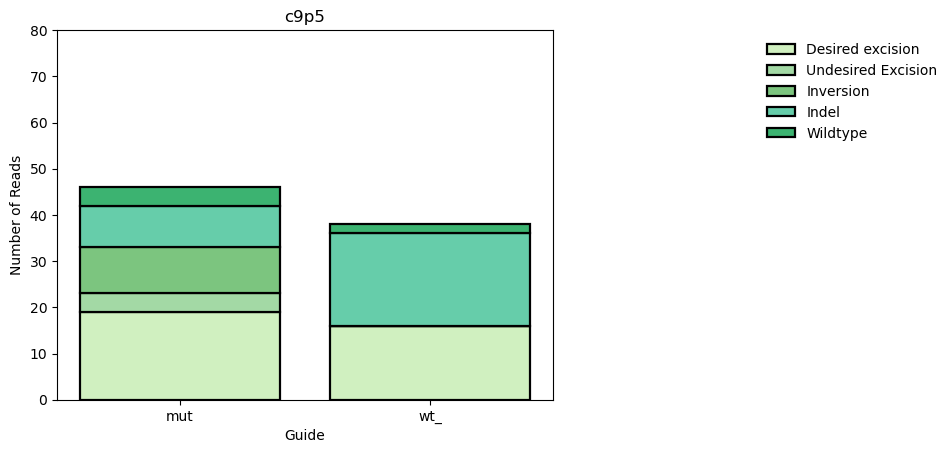

,Desired excision,Undesired Excision,Inversion,Indel,Wildtype,Allele
2,0.413043,0.086957,0.217391,0.195652,0.086957,mut
3,0.421053,0.0,0.0,0.526316,0.052632,wt_


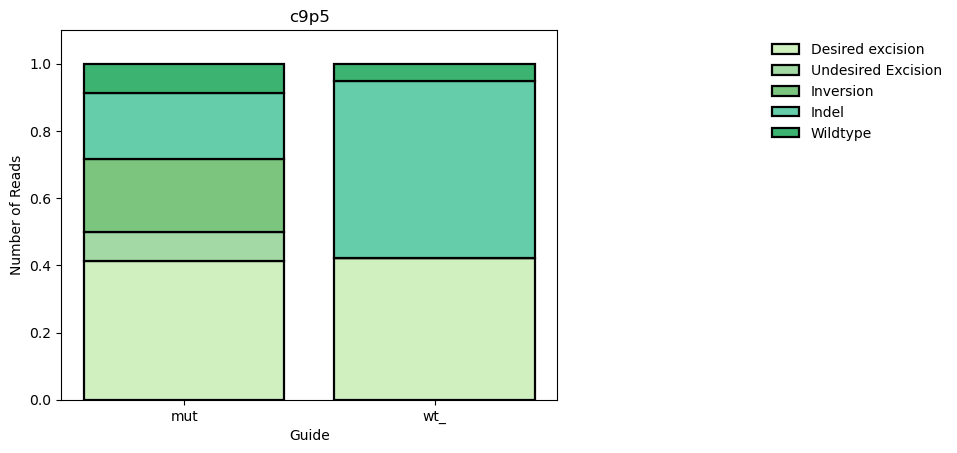

,Cell Line,Allele,Group,Name,Desired excision,Undesired Excision,Inversion,Indel,Wildtype,Guide
0,c9p4,mut,c9p4_mut_g11c9p4_mut_g12c9p4_mut_g13c9p4_mut_g4,m84127_240712_175808_s4/246483519/ccsm84127_24...,32,5,4,13,5,g11g12g13_g4
1,c9p4,wt_,c9p4_wt_g11c9p4_wt_g12c9p4_wt_g13c9p4_wt_g4,m84127_240712_175808_s4/24382007/ccsm84127_240...,15,2,0,38,3,g11g12g13_g4
2,c9p5,mut,c9p5_mut_g11c9p5_mut_g12c9p5_mut_g13c9p5_mut_g4,m84127_240802_194716_s2/91030239/ccsm84127_240...,19,4,10,9,4,g11g12g13_g4
3,c9p5,wt_,c9p5_wt_g11c9p5_wt_g12c9p5_wt_g13c9p5_wt_g4,m84127_240802_194716_s2/218432833/ccsm84127_24...,16,0,0,20,2,g11g12g13_g4
4,c9p8,mut,c9p8_mut_g11c9p8_mut_g12c9p8_mut_g13c9p8_mut_g4,m84127_240802_194716_s2/23790670/ccsm84127_240...,22,4,0,5,6,g11g12g13_g4
5,c9p8,wt_,c9p8_wt_g11c9p8_wt_g12c9p8_wt_g13c9p8_wt_g4,m84127_240712_175808_s4/191498582/ccsm84127_24...,17,2,0,31,1,g11g12g13_g4
6,c9p9,mut,c9p9_mut_g11c9p9_mut_g12c9p9_mut_g13c9p9_mut_g4,m84127_240802_191544_s1/46268837/ccsm84127_240...,10,3,0,3,1,g11g12g13_g4
7,c9p9,wt_,c9p9_wt_g11c9p9_wt_g12c9p9_wt_g4,m84127_240802_191544_s1/190515966/ccsm84127_24...,3,0,0,5,1,g11g12_g4


,Cell Line,Allele,Group,Name,Desired excision,Undesired Excision,Inversion,Indel,Wildtype,Guide
4,c9p8,mut,c9p8_mut_g11c9p8_mut_g12c9p8_mut_g13c9p8_mut_g4,m84127_240802_194716_s2/23790670/ccsm84127_240...,22,4,0,5,6,g11g12g13_g4
5,c9p8,wt_,c9p8_wt_g11c9p8_wt_g12c9p8_wt_g13c9p8_wt_g4,m84127_240712_175808_s4/191498582/ccsm84127_24...,17,2,0,31,1,g11g12g13_g4


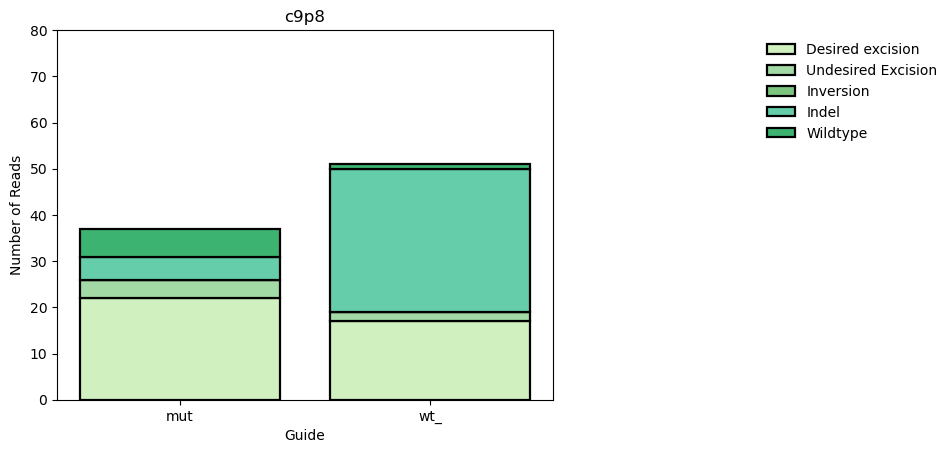

,Desired excision,Undesired Excision,Inversion,Indel,Wildtype,Allele
4,0.594595,0.108108,0.0,0.135135,0.162162,mut
5,0.333333,0.039216,0.0,0.607843,0.019608,wt_


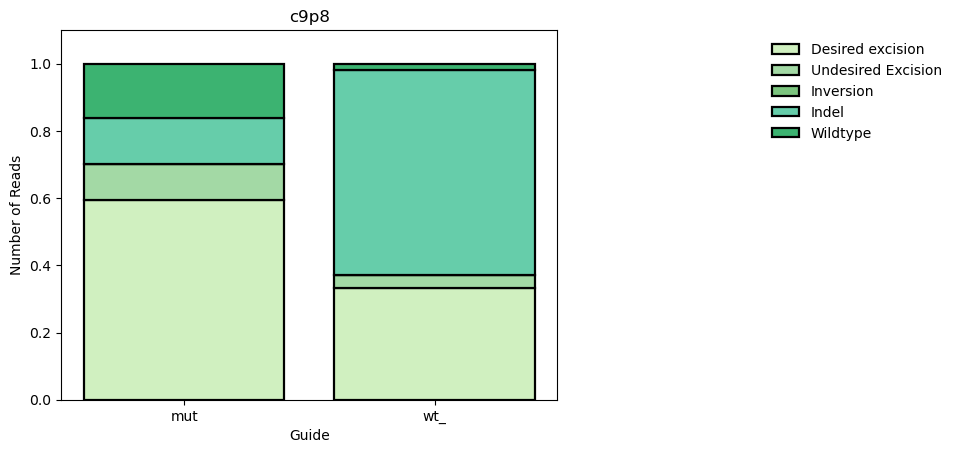

,Cell Line,Allele,Group,Name,Desired excision,Undesired Excision,Inversion,Indel,Wildtype,Guide
0,c9p4,mut,c9p4_mut_g11c9p4_mut_g12c9p4_mut_g13c9p4_mut_g4,m84127_240712_175808_s4/246483519/ccsm84127_24...,32,5,4,13,5,g11g12g13_g4
1,c9p4,wt_,c9p4_wt_g11c9p4_wt_g12c9p4_wt_g13c9p4_wt_g4,m84127_240712_175808_s4/24382007/ccsm84127_240...,15,2,0,38,3,g11g12g13_g4
2,c9p5,mut,c9p5_mut_g11c9p5_mut_g12c9p5_mut_g13c9p5_mut_g4,m84127_240802_194716_s2/91030239/ccsm84127_240...,19,4,10,9,4,g11g12g13_g4
3,c9p5,wt_,c9p5_wt_g11c9p5_wt_g12c9p5_wt_g13c9p5_wt_g4,m84127_240802_194716_s2/218432833/ccsm84127_24...,16,0,0,20,2,g11g12g13_g4
4,c9p8,mut,c9p8_mut_g11c9p8_mut_g12c9p8_mut_g13c9p8_mut_g4,m84127_240802_194716_s2/23790670/ccsm84127_240...,22,4,0,5,6,g11g12g13_g4
5,c9p8,wt_,c9p8_wt_g11c9p8_wt_g12c9p8_wt_g13c9p8_wt_g4,m84127_240712_175808_s4/191498582/ccsm84127_24...,17,2,0,31,1,g11g12g13_g4
6,c9p9,mut,c9p9_mut_g11c9p9_mut_g12c9p9_mut_g13c9p9_mut_g4,m84127_240802_191544_s1/46268837/ccsm84127_240...,10,3,0,3,1,g11g12g13_g4
7,c9p9,wt_,c9p9_wt_g11c9p9_wt_g12c9p9_wt_g4,m84127_240802_191544_s1/190515966/ccsm84127_24...,3,0,0,5,1,g11g12_g4


,Cell Line,Allele,Group,Name,Desired excision,Undesired Excision,Inversion,Indel,Wildtype,Guide
6,c9p9,mut,c9p9_mut_g11c9p9_mut_g12c9p9_mut_g13c9p9_mut_g4,m84127_240802_191544_s1/46268837/ccsm84127_240...,10,3,0,3,1,g11g12g13_g4
7,c9p9,wt_,c9p9_wt_g11c9p9_wt_g12c9p9_wt_g4,m84127_240802_191544_s1/190515966/ccsm84127_24...,3,0,0,5,1,g11g12_g4


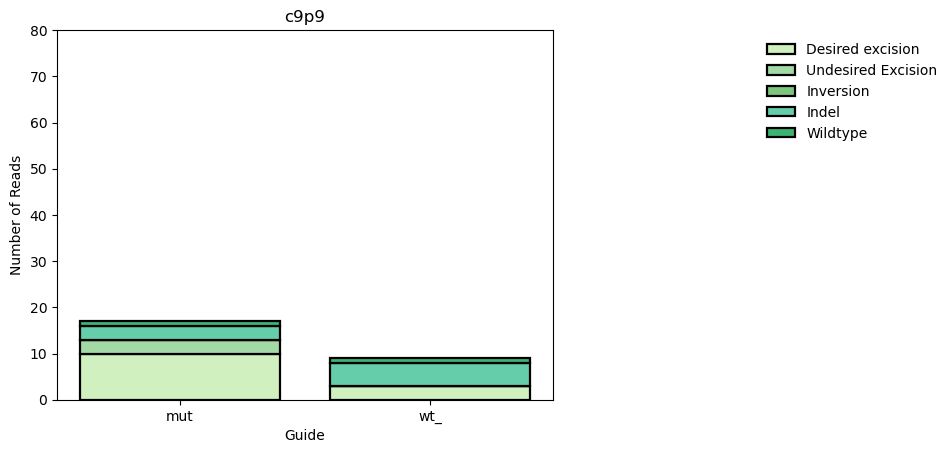

,Desired excision,Undesired Excision,Inversion,Indel,Wildtype,Allele
6,0.588235,0.176471,0.0,0.176471,0.058824,mut
7,0.333333,0.0,0.0,0.555556,0.111111,wt_


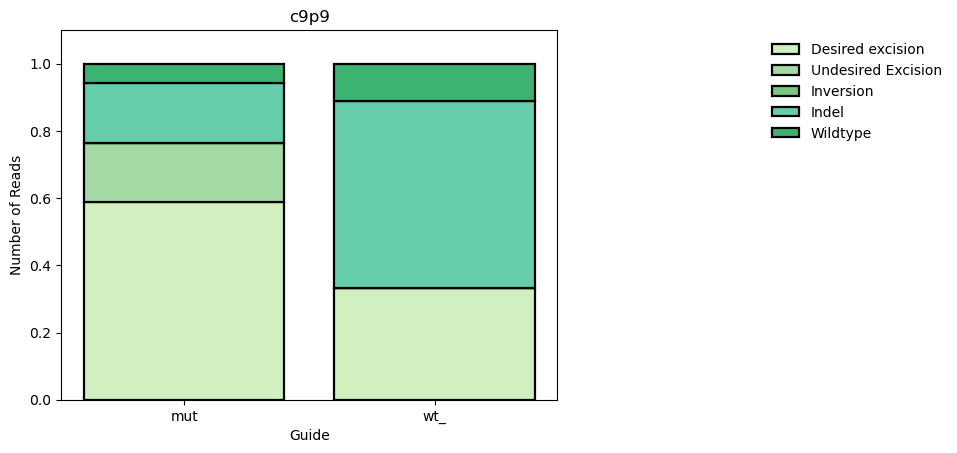

In [29]:
import os
import matplotlib.pyplot as plt

global_value = 0
# Function to generate filenames
def generate_filename(directory='images', extension='png'):
    global global_value  # Declare that we are using the global variable
    if not os.path.exists(directory):
        os.makedirs(directory)
    global_value += 1  # Increment the global value
    return os.path.join(directory, f'file_{global_value}.{extension}')


#making plots for the more coarse grained situation (desired excision, undesired excision,  inversion, wt, indel - indels
#might also be sequencing errors
corse_categories = ['Desired Excison', 'Undesired Excision', 'Indel Extending into Exonic Region']
read_table_corse = pd.DataFrame()
read_table_corse['Group'] = mut_exc_read_table['Group']
read_table_corse['Name'] = mut_exc_read_table['Name']
read_table_corse['Desired excision'] = mut_exc_read_table['Desired excision']
#excision that extends into exon1 or exon 2
read_table_corse['Undesired Excision'] = mut_exc_read_table['Undesired excision type I'] + mut_exc_read_table['Undesired excision type II']
#inversions (which I manually identified)
read_table_corse['Inversion'] = mut_exc_read_table['Inversion']
#indels which are in the guide region
read_table_corse['Indel'] =  mut_exc_read_table['Indel type II']
#wild type! (ALL else)
read_table_corse['Wildtype'] = mut_exc_read_table['Wild-type'] + mut_exc_read_table['Indel type III']

print(sum(read_table_corse['Desired excision']))
print(sum(read_table_corse['Undesired Excision']))
print(sum(read_table_corse['Inversion']))
print(sum(read_table_corse['Indel']))
print(sum(read_table_corse['Wildtype']))

display(read_table_corse)
read_table_corse.to_csv("coarse_breakdown_reads.csv", index=False)
read_table_corse_by_group = read_table_corse.groupby('Group').sum().reset_index()
read_table_corse_by_group.to_csv("coarse_breakdown_summary.csv", index=False)

grouped_sum = read_table_corse.groupby('Group').sum()
grouped_sum = grouped_sum.reset_index()
grouped_sum['Cell Line'] = [name[:4] for name in grouped_sum['Group']]
grouped_sum['Guide'] = [name[-3:] for name in grouped_sum['Group']]
grouped_sum['Allele'] = [name[5:8] for name in grouped_sum['Group']]

mut_exc_read_table['Cell Line'] = [name[:4] for name in mut_exc_read_table['Group']]
mut_exc_read_table['Guide'] = [name[-3:] for name in mut_exc_read_table['Group']]
mut_exc_read_table['Allele'] = [name[5:8] for name in mut_exc_read_table['Group']]

#seperating by cell line
c9p4_corse = grouped_sum[grouped_sum['Cell Line'] == 'c9p4']
c9p5_course = grouped_sum[grouped_sum['Cell Line'] == 'c9p5']
c9p8_course = grouped_sum[grouped_sum['Cell Line'] == 'c9p8']
c9p9_course = grouped_sum[grouped_sum['Cell Line'] == 'c9p9']

#seperating by allele type
c9p4_corse_wt = c9p4_corse[c9p4_corse['Allele'] == 'wt_']
c9p5_corse_wt = c9p5_course[c9p5_course['Allele'] == 'wt_']
c9p8_corse_wt = c9p8_course[c9p8_course['Allele'] == 'wt_']
c9p9_corse_wt = c9p9_course[c9p9_course['Allele'] == 'wt_']

c9p4_corse_mut = c9p4_corse[c9p4_corse['Allele'] == 'mut']
c9p5_corse_mut = c9p5_course[c9p5_course['Allele'] == 'mut']
c9p8_corse_mut = c9p8_course[c9p8_course['Allele'] == 'mut']
c9p9_corse_mut = c9p9_course[c9p9_course['Allele'] == 'mut']


def corse_stacked_bar(tbl, column_names, title = None, ylabel = 'Number of Reads', bars = 'Guide', y_lim = (0,1.1)):
    y_labels = tbl[bars]
    colors = [
    '#d0f0c0',  # Pale Green
    '#a3d9a5',  # Light Moss Green
    '#7cc57f',  # Light Olive Green
    '#66cdaa',  # Medium Aquamarine
    '#3cb371',  # Medium Sea Green
    '#2e8b57',  # Sea Green
    '#228b22',  # Forest Green
    '#006400',  # Dark Green
    '#004d00'   # Very Dark Green
]

    bottoms = [0] * len(y_labels)
    for i in range(len(column_names)):
        column_name = column_names[i]
        plt.bar(y_labels, tbl[column_name], bottom=bottoms, color=colors[i], label=f'Segment {i+1}', edgecolor='black', linewidth=1.6)
        # Update bottoms to include the height of the newly plotted segment
        bottoms = [b + s for b, s in zip(bottoms, tbl[column_name])]
        plt.ylim(y_lim)


    plt.legend(column_names,
               loc = 'upper right',
              frameon=False,
              bbox_to_anchor = (1.8,1))
    
    plt.title(title)
    plt.xlabel('Guide')
    plt.ylabel(ylabel)
       # Save and show the plot
    filename = generate_filename()
    plt.savefig(filename)
    plt.show()


for cell_line in mut_exc_read_table['Cell Line'].unique():
    all_numeric_cols = ['Desired excision',
                                 'Undesired excision type I',
                                 'Undesired excision type II',
                                 'Indel type I',
                                 'Indel type II',
                                 'Indel type III',
                                 'Indel Type IV',
                                 'Inversion',
                                 'Wild-type']

    #extract the table for the cell line of interest
    tbl = mut_exc_read_table[mut_exc_read_table['Cell Line'] == cell_line]
    tbl = tbl.groupby(['Guide', 'Allele']).sum()
    tbl.reset_index()

    tbl['Cell Line'] = [name[:4] for name in tbl['Group']]
    tbl['Guide'] = [name[-3:] for name in tbl['Group']]
    tbl['Allele'] = [name[5:8] for name in tbl['Group']]

    tbl_wt = tbl[tbl['Allele'] == 'wt_']
    tbl_mut = tbl[tbl['Allele'] == 'mut']

    tbl_row_sums_wt = tbl_wt[all_numeric_cols].sum(axis=1)
    tbl_row_sums_mut = tbl_mut[all_numeric_cols].sum(axis=1)

    tbl_wt_norm = tbl_wt[all_numeric_cols].div(tbl_row_sums_wt, axis = 0) #normalizing the wt tbl
    tbl_mut_norm = tbl_mut[all_numeric_cols].div(tbl_row_sums_mut, axis = 0) #normalizing the mut tbl

    tbl_wt_norm['Group'] = tbl_wt['Group']
    tbl_mut_norm['Group'] = tbl_mut['Group']

    #adding the non-numeric columns back to the tables
    tbl_wt_norm['Cell Line'] = [name[:4] for name in tbl_wt_norm['Group']]
    tbl_wt_norm['Guide'] = [name[-3:] for name in tbl_wt_norm['Group']]
    tbl_wt_norm['Allele'] = [name[5:8] for name in tbl_wt_norm['Group']]

    #adding the non-numeric columns back to the tables
    tbl_mut_norm['Cell Line'] = [name[:4] for name in tbl_mut_norm['Group']]
    tbl_mut_norm['Guide'] = [name[-3:] for name in tbl_mut_norm['Group']]
    tbl_mut_norm['Allele'] = [name[5:8] for name in tbl_mut_norm['Group']]

    corse_stacked_bar(tbl_wt, all_numeric_cols, title = str(cell_line) + 'wt_', y_lim = (0,25))
    corse_stacked_bar(tbl_mut, all_numeric_cols, title = str(cell_line) + 'mut', y_lim = (0,25))
    corse_stacked_bar(tbl_wt_norm, all_numeric_cols, title = str(cell_line) + 'wt_')
    corse_stacked_bar(tbl_mut_norm, all_numeric_cols, title = str(cell_line) + 'mut')

numeric_cols = ['Desired excision', 'Undesired Excision', 'Inversion', 'Indel', 'Wildtype']
corse_stacked_bar(c9p4_corse_wt, numeric_cols, title = 'c9p4 WT', y_lim = (0,25))
corse_stacked_bar(c9p5_corse_wt, numeric_cols, title = 'c9p5 WT',  y_lim = (0,25))
corse_stacked_bar(c9p8_corse_wt, numeric_cols, title = 'c9p8 WT',  y_lim = (0,25))

corse_stacked_bar(c9p9_corse_wt, numeric_cols, title = 'c9p9 WT',  y_lim = (0,25))
corse_stacked_bar(c9p4_corse_mut, numeric_cols, title = 'c9p4 MUT',  y_lim = (0,25))
corse_stacked_bar(c9p5_corse_mut, numeric_cols, title = 'c9p5 MUT',  y_lim = (0,25))
corse_stacked_bar(c9p8_corse_mut, numeric_cols, title = 'c9p8 MUT',  y_lim = (0,25))
corse_stacked_bar(c9p9_corse_mut, numeric_cols, title = 'c9p9 MUT',  y_lim = (0,25))

numeric_cols = ['Desired excision', 'Undesired Excision', 'Inversion', 'Indel', 'Wildtype']

c9p4_corse_wt_norm = c9p4_corse_wt[numeric_cols].div(c9p4_corse_wt[numeric_cols].sum(axis=1), axis = 0)
c9p4_corse_wt_norm["Group"] = c9p4_corse_wt["Group"]
c9p4_corse_wt_norm["Guide"] = c9p4_corse_wt["Guide"]
corse_stacked_bar(c9p4_corse_wt_norm, numeric_cols, title = 'c9p4 WT')

c9p5_corse_wt_norm = c9p5_corse_wt[numeric_cols].div(c9p5_corse_wt[numeric_cols].sum(axis=1), axis = 0)
c9p5_corse_wt_norm["Group"] = c9p5_corse_wt["Group"]
c9p5_corse_wt_norm["Guide"] = c9p5_corse_wt["Guide"]
corse_stacked_bar(c9p5_corse_wt_norm, numeric_cols, title = 'c9p5 WT')

c9p8_corse_wt_norm = c9p8_corse_wt[numeric_cols].div(c9p8_corse_wt[numeric_cols].sum(axis=1), axis = 0)
c9p8_corse_wt_norm["Group"] = c9p8_corse_wt["Group"]
c9p8_corse_wt_norm["Guide"] = c9p8_corse_wt["Guide"]
corse_stacked_bar(c9p8_corse_wt_norm, numeric_cols, title = 'c9p8 WT')

c9p9_corse_wt_norm = c9p9_corse_wt[numeric_cols].div(c9p9_corse_wt[numeric_cols].sum(axis=1), axis = 0)
c9p9_corse_wt_norm["Group"] = c9p9_corse_wt["Group"]
c9p9_corse_wt_norm["Guide"] = c9p9_corse_wt["Guide"]
corse_stacked_bar(c9p9_corse_wt_norm, numeric_cols, title = 'c9p9 WT')

c9p4_corse_mut_norm = c9p4_corse_mut[numeric_cols].div(c9p4_corse_mut[numeric_cols].sum(axis=1), axis = 0)
c9p4_corse_mut_norm["Group"] = c9p4_corse_mut["Group"]
c9p4_corse_mut_norm["Guide"] = c9p4_corse_mut["Guide"]
corse_stacked_bar(c9p4_corse_mut_norm, numeric_cols, title = 'c9p4 MUT')

c9p5_corse_mut_norm = c9p5_corse_wt[numeric_cols].div(c9p5_corse_wt[numeric_cols].sum(axis=1), axis = 0)
c9p5_corse_mut_norm["Group"] = c9p5_corse_mut["Group"]
c9p5_corse_mut_norm["Guide"] = c9p5_corse_mut["Guide"]
corse_stacked_bar(c9p5_corse_mut_norm, numeric_cols, title = 'c9p5 MUT')

c9p8_corse_mut_norm = c9p8_corse_wt[numeric_cols].div(c9p8_corse_wt[numeric_cols].sum(axis=1), axis = 0)
c9p8_corse_mut_norm["Group"] = c9p8_corse_mut["Group"]
c9p8_corse_mut_norm["Guide"] = c9p8_corse_mut["Guide"]
corse_stacked_bar(c9p8_corse_mut_norm, numeric_cols, title = 'c9p8 MUT')

c9p9_corse_mut_norm = c9p9_corse_wt[numeric_cols].div(c9p9_corse_wt[numeric_cols].sum(axis=1), axis = 0)
c9p9_corse_mut_norm["Group"] = c9p9_corse_mut["Group"]
c9p9_corse_mut_norm["Guide"] = c9p9_corse_mut["Guide"]
corse_stacked_bar(c9p9_corse_mut_norm, numeric_cols, title = 'c9p9 MUT')

#grouping them all together even more!
combined_stacked_bar_all = grouped_sum.groupby('Guide').sum()
combined_stacked_bar_all = combined_stacked_bar_all.reset_index()
display()

corse_stacked_bar(combined_stacked_bar_all, ['Desired excision', 'Undesired Excision', 'Inversion', 'Indel', 'Wildtype'], 'All Conditions', y_lim = (0,100))
combined_stacked_bar_all_norm = pd.DataFrame()

row_sums = combined_stacked_bar_all[['Desired excision', 'Undesired Excision', 'Inversion', 'Indel', 'Wildtype']].sum(axis=1)
combined_stacked_bar_all_norm[['Desired excision', 'Undesired Excision', 'Inversion', 'Indel', 'Wildtype']] = combined_stacked_bar_all[['Desired excision', 'Undesired Excision', 'Inversion', 'Indel', 'Wildtype']].div(row_sums, axis=0)
combined_stacked_bar_all_norm['Guide'] = combined_stacked_bar_all['Guide']
combined_stacked_bar_all_norm['Allele'] = combined_stacked_bar_all['Allele']
corse_stacked_bar(combined_stacked_bar_all_norm, numeric_cols, ylabel = '% occurence', title = 'Editing outcome Across Alleles and Patient Line', y_lim = (0,1.1))

for cell_line in grouped_sum['Cell Line'].unique():
    mut_wt_tbl = grouped_sum.groupby(['Cell Line', 'Allele']).sum().reset_index()
    corse_stacked_bar(mut_wt_tbl[mut_wt_tbl['Cell Line'] == cell_line],
                                 numeric_cols, bars = 'Allele', title = cell_line, y_lim = (0,80))


    row_sums = mut_wt_tbl[mut_wt_tbl['Cell Line'] == cell_line][['Desired excision', 'Undesired Excision', 'Inversion', 'Indel', 'Wildtype']].sum(axis=1)
    mut_wt_tbl_norm = mut_wt_tbl[mut_wt_tbl['Cell Line'] == cell_line][numeric_cols].div(row_sums, axis=0)
    mut_wt_tbl_norm['Allele'] = mut_wt_tbl[mut_wt_tbl['Cell Line'] == cell_line]['Allele']

    corse_stacked_bar(mut_wt_tbl_norm,
                                 numeric_cols, bars = 'Allele', title = cell_line, y_lim = (0,1.1))


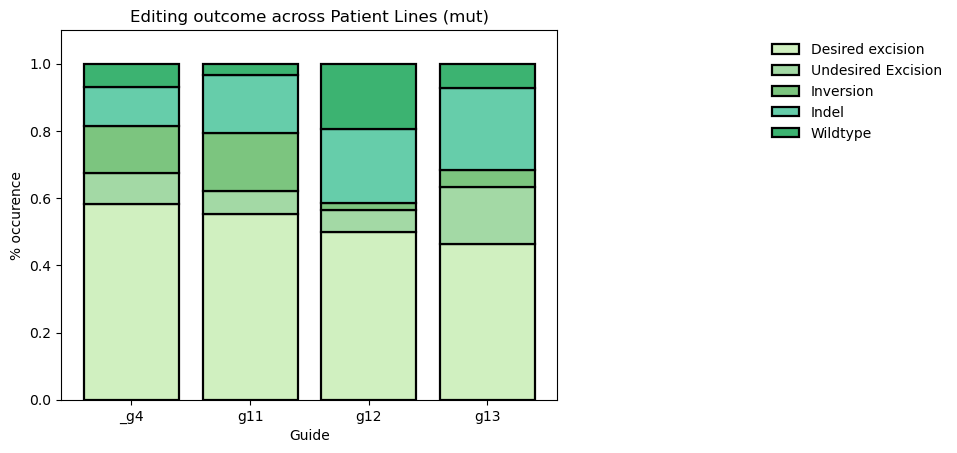

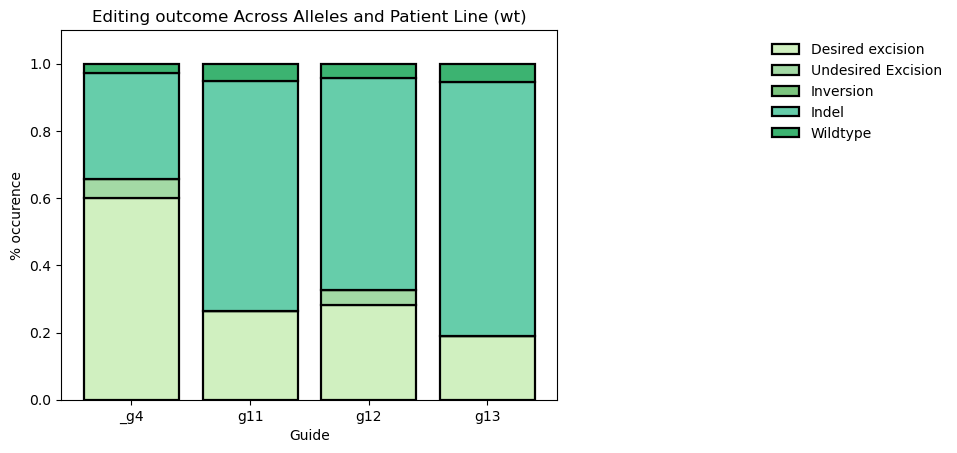

In [32]:
combined_stacked_bar_all
combined_stacked_bar_all_norm_mut = pd.DataFrame()
grouped_sum_mut = grouped_sum[grouped_sum['Allele'] == 'mut']
grouped_sum_wt = grouped_sum[grouped_sum['Allele'] == 'wt_']
combined_stacked_bar_all_mut = grouped_sum_mut.groupby('Guide').sum()
combined_stacked_bar_all_mut = combined_stacked_bar_all_mut.reset_index()
combined_stacked_bar_all_wt = grouped_sum_wt.groupby('Guide').sum()
combined_stacked_bar_all_wt = combined_stacked_bar_all_wt.reset_index()
combined_stacked_bar_all_norm_mut

row_sums_mut = combined_stacked_bar_all_mut[['Desired excision', 'Undesired Excision', 'Inversion', 'Indel', 'Wildtype']].sum(axis=1)
row_sums_wt = combined_stacked_bar_all_wt[['Desired excision', 'Undesired Excision', 'Inversion', 'Indel', 'Wildtype']].sum(axis=1)

combined_stacked_bar_all_mut_norm = combined_stacked_bar_all_mut[['Desired excision', 'Undesired Excision', 'Inversion', 'Indel', 'Wildtype']].div(row_sums_mut, axis=0)
combined_stacked_bar_all_wt_norm = combined_stacked_bar_all_wt[['Desired excision', 'Undesired Excision', 'Inversion', 'Indel', 'Wildtype']].div(row_sums_wt, axis=0)
combined_stacked_bar_all_mut_norm['Guide'] = combined_stacked_bar_all['Guide']
combined_stacked_bar_all_wt_norm['Guide'] = combined_stacked_bar_all['Guide']

combined_stacked_bar_all_mut_norm
corse_stacked_bar(combined_stacked_bar_all_mut_norm, numeric_cols, ylabel = '% occurence', title = 'Editing outcome across Patient Lines (mut)', y_lim = (0,1.1))
corse_stacked_bar(combined_stacked_bar_all_wt_norm, numeric_cols, ylabel = '% occurence', title = 'Editing outcome Across Alleles and Patient Line (wt)', y_lim = (0,1.1))

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def make_bar_chart_combined(tuple_lst_1, tuple_lst_2, tuple_lst_3, title):
    # Convert lists of tuples into numpy arrays
    array_1 = np.array(tuple_lst_1)
    array_2 = np.array(tuple_lst_2)
    array_3 = np.array(tuple_lst_3)

    # Stack arrays to form a 3D array where the first dimension is the list index
    stacked_arrays = np.stack([array_1, array_2, array_3], axis=0)

    # Calculate the mean and standard deviation across the lists
    avg_tuples = np.mean(stacked_arrays)
    sd_tuples = np.std(stacked_arrays)

    # Print averages and standard deviations
    print("Average Tuples:\n", avg_tuples)
    print("Standard Deviation Tuples:\n", sd_tuples)

def make_bar_chart(tuple_lst, title):
    #might just do the inversions manually....,
    groups = ['g4', 'g11', 'g12', 'g13']
    categories = ['Intronic Excision',
                  "Excision with overlap in Exon1",
                  "Excision with overlap in Exon2",
                 "Excision with overlap in Exon1 and Exon2",
                 "Intronic Deletion",
                 "Deletion in Exon1",
                 "Deletion in Exon2",
                 "No Deletions"]


    colors = [
    '#d0f0c0',  # Pale Green
    '#90ee90',  # Light Green
    '#3cb371',  # Medium Sea Green
    '#00fa9a',  # Medium Spring Green
    '#2e8b57',  # Sea Green
    '#228b22',  # Forest Green
    '#556b2f',  # Dark Olive Green
    '#006400'   # Dark Green
    ]

    bottom = [0] * len(categories)  # Initialize bottom positions for stacking
    # Plot each segment of the bar

    stacked = [[tuple_lst['g4'][0],  tuple_lst['g11'][0], tuple_lst['g12'][0], tuple_lst['g13'][0]],
               [tuple_lst['g4'][1],  tuple_lst['g11'][1], tuple_lst['g12'][1], tuple_lst['g13'][1]],
               [tuple_lst['g4'][2],  tuple_lst['g11'][2], tuple_lst['g12'][2], tuple_lst['g13'][2]],
               [tuple_lst['g4'][3],  tuple_lst['g11'][3], tuple_lst['g12'][3], tuple_lst['g13'][3]],
               [tuple_lst['g4'][4],  tuple_lst['g11'][4], tuple_lst['g12'][4], tuple_lst['g13'][4]],
               [tuple_lst['g4'][5],  tuple_lst['g11'][5], tuple_lst['g12'][5], tuple_lst['g13'][5]],
               [tuple_lst['g4'][6],  tuple_lst['g11'][6], tuple_lst['g12'][6], tuple_lst['g13'][6]],
               [tuple_lst['g4'][7],  tuple_lst['g11'][7], tuple_lst['g12'][7], tuple_lst['g13'][7]]]

    #THE C9P4 MUTANT GRAPH
    # Initialize bottom heights
    bottoms = [0] * len(groups)

    # Plotting the stacked bar graph
    for i in range(len(stacked)):
        plt.bar(groups, stacked[i], bottom=bottoms, color=colors[i], label=f'Segment {i+1}', edgecolor = 'black', linewidth = 1.4)
        # Update bottoms to include the height of the newly plotted segment
        bottoms = [b + s for b, s in zip(bottoms, stacked[i])]

    # Adding labels and title
    plt.xlabel('Guide')
    plt.ylabel('Number of Reads')
    plt.title(title)

    # Adding a legend
    plt.legend(categories,
              loc = 'upper right',
              frameon=False,
              bbox_to_anchor = (1.8,1))

    # Display the graph
    plt.xticks(rotation=45)
    plt.show()



# make_bar_chart(c9p4_mutant, 'c9p4_mutant')
# make_bar_chart(c9p4_wt, 'c9p4_wildtype')

# make_bar_chart(c9p8_mutant, 'c9p8_mutant')
# make_bar_chart(c9p8_wt, 'c9p8_wildtype')

# make_bar_chart(c9p5_mutant, 'c9p5_mutant')
# make_bar_chart(c9p5_wt, 'c9p5_wildtype')

{'g4': (13, 0, 0, 0, 1, 2, 3, 0), 'g11': (4, 0, 0, 0, 5, 2, 3, 0), 'g12': (10, 0, 0, 0, 7, 3, 4, 0), 'g13': (10, 0, 0, 0, 6, 9, 5, 0)}
13
(13, 0, 0, 0, 1, 2, 3, 0)


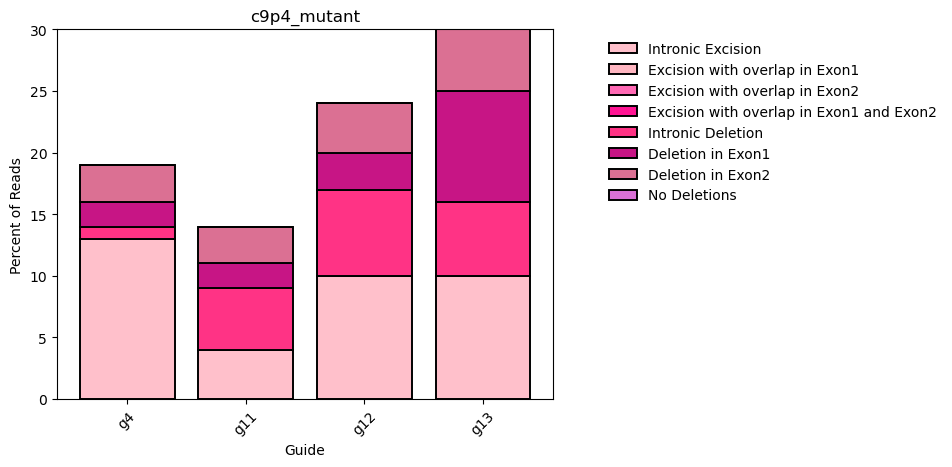

7
(7, 0, 0, 0, 1, 0, 1, 0)


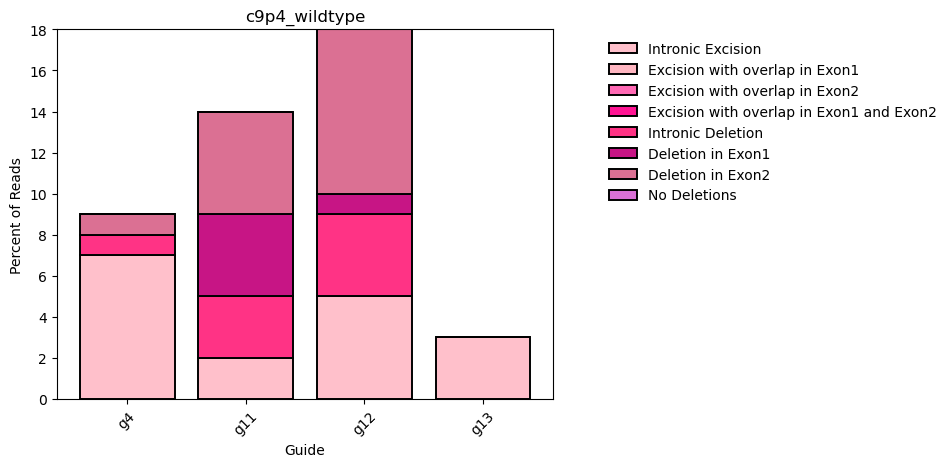

3
(3, 0, 0, 0, 7, 1, 3, 0)


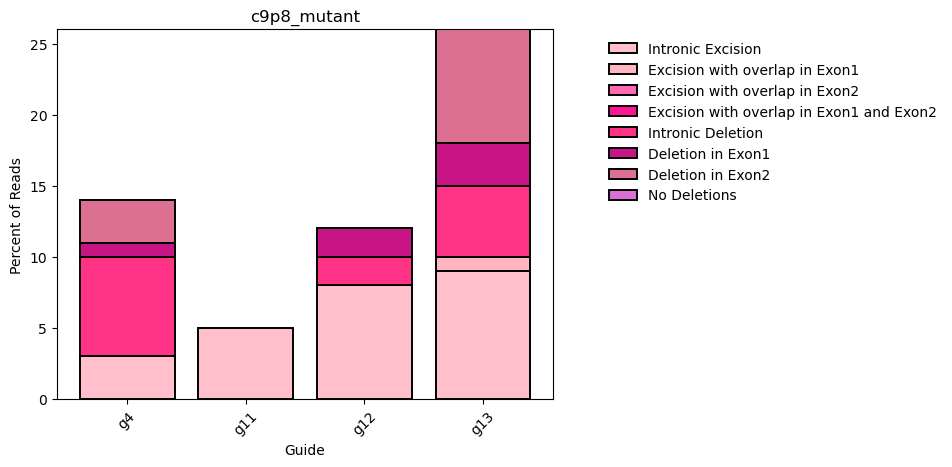

{'g4': (5, 0, 0, 0, 1, 1, 0, 0), 'g11': (3, 0, 0, 0, 0, 0, 0, 0), 'g12': (8, 0, 0, 0, 3, 0, 3, 0), 'g13': (3, 0, 0, 0, 1, 0, 0, 0)}
5
(5, 0, 0, 0, 1, 1, 0, 0)


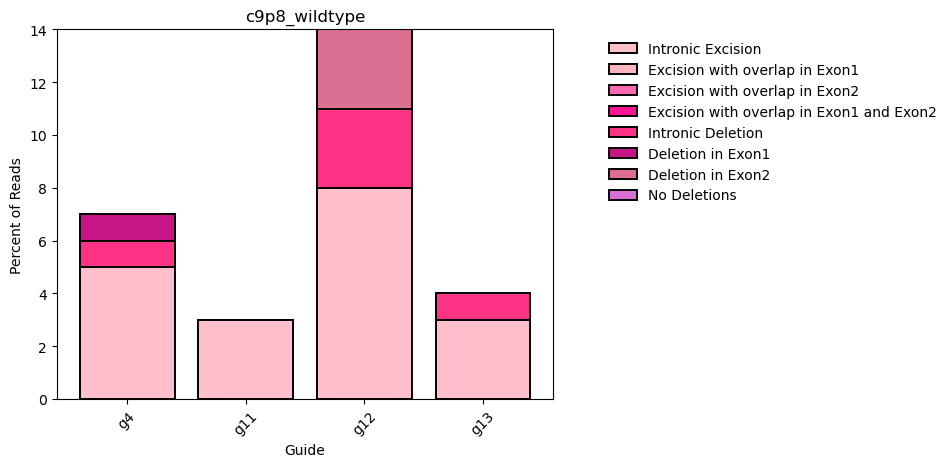

10
(10, 0, 0, 0, 3, 5, 10, 0)


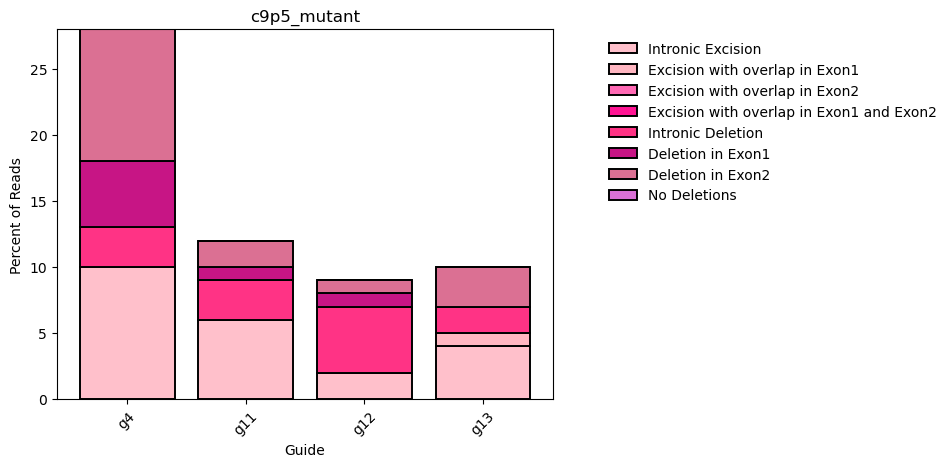

9
(9, 0, 0, 0, 1, 0, 0, 0)


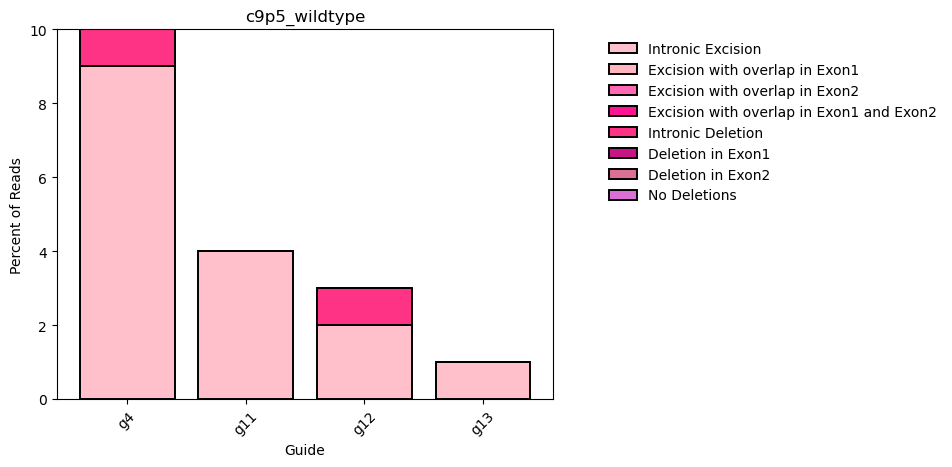

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def make_bar_chart_combined(tuple_lst_1, tuple_lst_2, tuple_lst_3, title):
    # Convert lists of tuples into numpy arrays
    array_1 = np.array(tuple_lst_1)
    array_2 = np.array(tuple_lst_2)
    array_3 = np.array(tuple_lst_3)

    # Stack arrays to form a 3D array where the first dimension is the list index
    stacked_arrays = np.stack([array_1, array_2, array_3], axis=0)

    # Calculate the mean and standard deviation across the lists
    avg_tuples = np.mean(stacked_arrays)
    sd_tuples = np.std(stacked_arrays)

    # Print averages and standard deviations
    print("Average Tuples:\n", avg_tuples)
    print("Standard Deviation Tuples:\n", sd_tuples)
    
#normalizing by the total number of reads (which isn't a lot).....
def make_bar_chart(tuple_lst, title):
    #might just do the inversions manually....,
    groups = ['g4', 'g11', 'g12', 'g13']
    categories = ['Intronic Excision',
                  "Excision with overlap in Exon1",
                  "Excision with overlap in Exon2",
                 "Excision with overlap in Exon1 and Exon2",
                 "Intronic Deletion",
                 "Deletion in Exon1",
                 "Deletion in Exon2",
                 "No Deletions"]


    colors = [
    '#d0f0c0',  # Pale Green
    '#90ee90',  # Light Green
    '#3cb371',  # Medium Sea Green
    '#00fa9a',  # Medium Spring Green
    '#2e8b57',  # Sea Green
    '#228b22',  # Forest Green
    '#556b2f',  # Dark Olive Green
    '#006400'   # Dark Green
    ]

    bottom = [0] * len(categories)  # Initialize bottom positions for stacking
    # Plot each segment of the bar

    print(tuple_lst['g4'][0])

    print(tuple_lst['g4'])
    total_g4 = 1
    total_g11 = 1
    total_g12 = 1
    total_g13 = 1

    stacked = [[tuple_lst['g4'][0]/total_g4,  tuple_lst['g11'][0]/total_g11, tuple_lst['g12'][0]/total_g12, tuple_lst['g13'][0]/total_g13],
               [tuple_lst['g4'][1]/total_g4,  tuple_lst['g11'][1]/total_g11, tuple_lst['g12'][1]/total_g12, tuple_lst['g13'][1]/total_g13],
               [tuple_lst['g4'][2]/total_g4,  tuple_lst['g11'][2]/total_g11, tuple_lst['g12'][2]/total_g12, tuple_lst['g13'][2]/total_g13],
               [tuple_lst['g4'][3]/total_g4,  tuple_lst['g11'][3]/total_g11, tuple_lst['g12'][3]/total_g12, tuple_lst['g13'][3]/total_g13],
               [tuple_lst['g4'][4]/total_g4,  tuple_lst['g11'][4]/total_g11, tuple_lst['g12'][4]/total_g12, tuple_lst['g13'][4]/total_g13],
               [tuple_lst['g4'][5]/total_g4,  tuple_lst['g11'][5]/total_g11, tuple_lst['g12'][5]/total_g12, tuple_lst['g13'][5]/total_g13],
               [tuple_lst['g4'][6]/total_g4,  tuple_lst['g11'][6]/total_g11, tuple_lst['g12'][6]/total_g12, tuple_lst['g13'][6]/total_g13],
               [tuple_lst['g4'][7]/total_g4,  tuple_lst['g11'][7]/total_g11, tuple_lst['g12'][7]/total_g12, tuple_lst['g13'][7]/total_g13]]

    # # Define the pinkish color palette
    colors = [
        '#FFC0CB',  # Soft Pink
        '#FFB6C1',  # Light Pink
        '#FF69B4',  # Pink
        '#FF1493',  # Hot Pink
        '#FF3385',  # Deep Pink
        '#C71585',  # Medium Violet Red
        '#DB7093',  # Pale Violet Red
        '#DA70D6'   # Orchid
    ]

    #THE C9P4 MUTANT GRAPH
    # Initialize bottom heights
    bottoms = [0] * len(groups)

    # Plotting the stacked bar graph
    for i in range(len(stacked)):
        plt.bar(groups, stacked[i], bottom=bottoms, color=colors[i], label=f'Segment {i+1}', edgecolor = 'black', linewidth = 1.4)
        # Update bottoms to include the height of the newly plotted segment
        bottoms = [b + s for b, s in zip(bottoms, stacked[i])]

    # Adding labels and title
    plt.xlabel('Guide')
    plt.ylabel('Percent of Reads')
    plt.title(title)

    # Adding a legend
    plt.legend(categories,
              loc = 'upper right',
              frameon=False,
              bbox_to_anchor = (1.8,1))

    # Display the graph
    plt.xticks(rotation=45)
    plt.show()


print(c9p4_mutant)

make_bar_chart(c9p4_mutant, 'c9p4_mutant')
make_bar_chart(c9p4_wt, 'c9p4_wildtype')

make_bar_chart(c9p8_mutant, 'c9p8_mutant')
print(c9p8_wt)
make_bar_chart(c9p8_wt, 'c9p8_wildtype')

make_bar_chart(c9p5_mutant, 'c9p5_mutant')
make_bar_chart(c9p5_wt, 'c9p5_wildtype')


#TODO (FROM THE NO DELETIONS EXCLUDE THOSE REVERSIONS - NEED TO SIFT THROGUH INDEPENDENTLY)
c9p4_reversions = []
c9p5_reversions = []
c9p8_reversions = []

c9p4_shifts = []
c9p5_shifts = []
c9p8_shifts = []

In [49]:
#if input a known interval of a heterozygous variant - will return the nucleotide sequence in that variant
#thereby allowing verification of the phasing (for instance if split a BAM into WT and MUT, and have a known snp present on one allele at a 
#specified interval
def find_interval(inbam, pos1, pos2):
    deletions = []
    count = 0

    for read in inbam.fetch("chr9", 27557179, 27580459):
        #need to take into account soft clipped bases

        count += 1
        ref_start = read.reference_start  # Correct attribute for reference start position
        if read.cigartuples[0][0] == 4:
            ref_start = ref_start - read.cigartuples[0][1]

        cigar = read.cigartuples

        #the bases traversed - where we are in the read
        l_read = 0
        #the exact start position of the read - where we are in the reference
        l = ref_start

        segment_index = 0
        for op, length in cigar:
            #if we are at the exonic region in the read
            if l + length > pos1:
                deletions.append(read.query_sequence[l_read + (pos1 - l):l_read + (pos2 - l)])
                break
                
            if op == 0:
                l_read += length
                l += length

            elif op == 1:  # Insertion (this is correct)
                l_read += length

            elif op == 2:  # Deletion (this is correct)
                l += length

            elif op == 3:  # Skipped region
                l += length #moving ahead in the reference

            elif op == 4:  # Soft clipping
                l_read += length
                l += length #
            elif op == 5:  # Hard clipping NOT SURE
                pass
            elif op == 6:  # Padding NOT SURE
                pass
            elif op == 7:  # Segment equal (this is correct)
                l_read += length
                l += length
            elif op == 8:  # seems to be sequence mismatcj - they both advance then NOT SURE
                l_read += length
                l += length
            else:
                raise ValueError(f"Unknown CIGAR operation code {op}")
            segment_index += 1
    return deletions

In [1]:
#verifuing the phasing for wt and mutant
c9p8_g13_wt = pysam.AlignmentFile("c9p8_samples_merged/WT_Biosample_12.fofn.pbmm2.repeats.bam%.bam.merged.bam", "rb" )
c9p8_g13_mutant = pysam.AlignmentFile("c9p8_samples_merged/WT_Biosample_12.fofn.pbmm2.repeats.bam%.bam.merged.bam", "rb" )
result = find_interval(c9p8_g13_wt, 27574803, 27574806)
result = find_interval(c9p8_g13_mutant, 27574804, 27574806)

NameError: name 'pysam' is not defined

In [52]:
#another categorization method 
#many of the indels are actually sequencing errors
#settled on categorizing into desired excisions, undesired excisions (exonic overlap + intronic), inversions and a neither category
#table to be used in PRISM plotting
corse_tbl = pd.DataFrame()
for index, row in read_table.iterrows():
    # inversion
    new_rows = []
    if row['inversion']:
        new_row = {
            'Group': row['group'],
            'Name': row['name'],
            'Desired excision': 0,
            'Undesired excision type': 0,
            'Inversion': 1,
            'No Excision or Inversion': 0
        }
    # undesired excision type I (overlaps with an exon)
    elif row['excision which overlaps with ex1'] or row['excision which overlaps with ex2'] or row['excision which overlaps with ex1 and ex2']:
        new_row = {
            'Group': row['group'],
            'Name': row['name'],
            'Desired excision': 0,
            'Undesired excision type': 1,
            'Inversion': 0,
            'No Excision or Inversion': 0
        }
    elif row['Intronic Excision?']:
        new_row = {
            'Group': row['group'],
            'Name': row['name'],
            'Desired excision': 1,
            'Undesired excision type': 0,
            'Inversion': 0,
            'No Excision or Inversion': 0
        }
    else:  # Changed from elif: to else:
        new_row = {
            'Group': row['group'],
            'Name': row['name'],
            'Desired excision': 0,
            'Undesired excision type': 0,
            'Inversion': 0,
            'No Excision or Inversion': 1
        }

    new_row_df = pd.DataFrame([new_row])
    corse_tbl = pd.concat([corse_tbl, new_row_df], ignore_index=True)

In [66]:
corse_tbl.groupby('Group').sum()

,Name,Desired excision,Undesired excision type,Inversion,No Excision or Inversion
Group,,,,,
c9p4_mut_g11,m84127_240712_175808_s4/246483519/ccsm84127_24...,4,0,2,0
c9p4_mut_g12,m84127_240712_175808_s4/204801393/ccsm84127_24...,10,0,0,10
c9p4_mut_g13,m84127_240802_194716_s2/177998463/ccsm84127_24...,10,0,1,6
c9p4_mut_g4,m84127_240802_194716_s2/58000941/ccsm84127_240...,13,0,1,3
c9p4_wt_g11,m84127_240712_175808_s4/24382007/ccsm84127_240...,2,0,0,9
c9p4_wt_g12,m84127_240712_175808_s4/64623199/ccsm84127_240...,5,0,0,14
c9p4_wt_g13,m84127_240802_194716_s2/149230529/ccsm84127_24...,3,0,0,13
c9p4_wt_g4,m84127_240712_175808_s4/123800984/ccsm84127_24...,7,0,0,7
c9p5_mut_g11,m84127_240802_194716_s2/91030239/ccsm84127_240...,6,0,3,4


In [55]:
mut_rows = corse_tbl[corse_tbl['Group'].str.contains('mut', case=False, na=False)]
mut_rows

,Group,Name,Desired excision,Undesired excision type,Inversion,No Excision or Inversion
0,c9p4_mut_g4,m84127_240802_194716_s2/58000941/ccs,1,0,0,0
1,c9p4_mut_g4,m84127_240712_175808_s4/50725613/ccs,1,0,0,0
2,c9p4_mut_g4,m84127_240712_175808_s4/128325484/ccs,1,0,0,0
3,c9p4_mut_g4,m84127_240712_175808_s4/97847419/ccs,1,0,0,0
4,c9p4_mut_g4,m84127_240712_175808_s4/152113895/ccs,1,0,0,0
5,c9p4_mut_g4,m84127_240712_175808_s4/267719799/ccs,1,0,0,0
6,c9p4_mut_g4,m84127_240712_175808_s4/243139731/ccs,1,0,0,0
7,c9p4_mut_g4,m84127_240802_194716_s2/83891685/ccs,0,0,0,1
8,c9p4_mut_g4,m84127_240712_175808_s4/246221909/ccs,1,0,0,0
9,c9p4_mut_g4,m84127_240712_175808_s4/5311150/ccs,1,0,0,0


In [58]:
wt_rows = corse_tbl[corse_tbl['Group'].str.contains('wt', case=False, na=False)]
wt_rows

,Group,Name,Desired excision,Undesired excision type,Inversion,No Excision or Inversion
60,c9p4_wt_g4,m84127_240712_175808_s4/123800984/ccs,1,0,0,0
61,c9p4_wt_g4,m84127_240712_175808_s4/120002150/ccs,1,0,0,0
62,c9p4_wt_g4,m84127_240712_175808_s4/248516024/ccs,1,0,0,0
63,c9p4_wt_g4,m84127_240712_175808_s4/116917146/ccs,1,0,0,0
64,c9p4_wt_g4,m84127_240712_175808_s4/188421000/ccs,0,0,0,1
65,c9p4_wt_g4,m84127_240712_175808_s4/246810774/ccs,0,0,0,1
66,c9p4_wt_g4,m84127_240712_175808_s4/125174170/ccs,0,0,0,1
67,c9p4_wt_g4,m84127_240712_175808_s4/210437935/ccs,1,0,0,0
68,c9p4_wt_g4,m84127_240712_175808_s4/48500461/ccs,0,0,0,1
69,c9p4_wt_g4,m84127_240712_175808_s4/44045276/ccs,0,0,0,1


In [62]:
c9p8_al = pysam.AlignmentFile('c9p8_samples_merged/MUTANT_Biosample_9.fofn.pbmm2.repeats.bam%.bam.merged.bam', "rb")

In [2]:
import pandas as pd

#summation over reads - for use in final table
grouped = mut_rows.groupby('Group').sum()
n = 3  # For example, extract the last 3 characters
grouped['GroupLastChars'] = grouped.index.str[-n:]  # Extract last 'n' chars from the group names
grouped_sorted = grouped.sort_values(by='GroupLastChars')
grouped_sorted = grouped_sorted.drop(columns=['GroupLastChars'])
display(grouped_sorted)


NameError: name 'mut_rows' is not defined